
Gonçalo Gouveia 2018277419|MEF

Joana Moura     2018279657|MEF

Jorge Silva     2018277634|MEF


Professores  © DEI2022/2023

Objetivo: 

*Para este projeto foram usados códigos disponibilizados dos trabalhos de aulas práticas.*

#Libraries

In [ ]:
#PLOT
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
#ML | data_manipulation

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.figure import Figure
from sklearn import datasets
from sklearn.preprocessing import MultiLabelBinarizer

warnings.filterwarnings('ignore')
! git clone https://github.com/spl-icsforth/FORTH_TRACE_DATASET.git


# https://github.com/miguelpmmarques/TCD
# https://github.com/leonorcoelh0/TCD/blob/main/Code/mainActivity.ipynb

fatal: destination path 'FORTH_TRACE_DATASET' already exists and is not an empty directory.


# DATA

In [ ]:
# para alem das 12 colunas que os ficheiros csv têm, adicionamos outra para identificar o ID do participante
head = ["deviceID","accX", "accY", "accZ", "gyroX","gyroY", "gyroZ", "magX", "magY", "magZ", "t", "label","partID"]

#part_data =pd.DataFrame()
#--- funcoes antigas
def getPartData(part):
  for i in range(1,6):
    new_data = pd.read_csv('FORTH_TRACE_DATASET/part' + str(part) + '/part' + str(part) + 'dev' + str(i) + '.csv', delimiter=',')
    if i==1:
      part_data = new_data
    else:
      part_data=np.vstack((part_data , new_data))

  data = pd.DataFrame(part_data, columns=head)
  data["partID"] = part
  return(data)


def get_all():
  A = getPartData(0)
  for i in range(1,14):
    part_data = getPartData(i)
    A = np.vstack((part_data,A))
  A = pd.DataFrame(A,columns= head)
  return A

#--- novas funcoes
# funcao para ler o ficheiro csv do dispositivo dev do participante part
# ja' resolvi o problema dos nan; as diferencas sao as linhas do pd.read_csv e do return, por causa do cabeçalho
def getDeviceData(part,dev=2):
    filename = 'part' + str(part) + 'dev' + str(dev) + '.csv'
    new_data = pd.read_csv('FORTH_TRACE_DATASET/part'+str(part)+'/' + filename, delimiter=',', names = head)
    new_data["partID"] = part     
    return pd.DataFrame(new_data)

# funcao para ler os ficheiro csv do dispositivo dev de todos os participantes;
def getDeviceData_allParticipants(dev=2):
    temp_data = pd.DataFrame(columns=head)
    for i in range(0,14):
        device_data = getDeviceData(i,dev)
        temp_data= temp_data.append(device_data)
    return pd.DataFrame(temp_data, columns=head)

#data= get_all()
data = getDeviceData_allParticipants()


act_labels = np.array([
    'Stand',
    'Sit',
    'Sit and Talk',
    'Walk',
    'Walk and Talk',
    'Climb Stairs (CS)',
    'CS and Talk',
    'Stand to Sit',
    'Sit to Stand',
    'Stand to Sit and Talk',
    'Sit to Stand and Talk',
    'Stand to Walk',
    'Walk to Stand',
    'Stand to CS/CS and Talk',
    'CS to Walk',
    'CS and Talk to Walk and Talk'
])

#Sensores
sens = ["ACC","GYRO","MAG"]

#Função para criar coluna com nomes (strings) dos movimentos
def label_to_move(label):
    return act_labels[label-1]

data['move'] = data['label'].map(label_to_move)


# calcula o modulo de um vetor com componentes x,y e z
def modulo(x,y,z):
  return np.sqrt(x**2+y**2+z**2)


data['acc_mod']  = modulo(data['accX'] , data['accY'] , data['accZ'])
data['gyro_mod'] = modulo(data['gyroX'], data['gyroY'], data['gyroZ'])
data['mag_mod']  = modulo(data['magX'] , data['magY'] , data['magZ'])

#criar a coluna target para o y (Atividade final - Target final, output da máquina)
Y_s = data['move'] #y1, target com strings dos movimentos
Y_n = data['label'] #y2, target com números de cada movimento

data = data[['accX','accY','accZ', 'magX', 'magY', 'magZ', 'gyroX', 'gyroY', 'gyroZ']]



Normalização dos dados

In [ ]:
#Normalizing dataset
#depois de dividir os dados em target column e x, a target column não é para normalizar
#usar Standard Scaler se desse 

data_norm = preprocessing.normalize(data)
scaled_df = pd.DataFrame(data_norm, columns=['accX','accY','accZ', 'magX', 'magY', 'magZ', 'gyroX', 'gyroY', 'gyroZ'])

#Depois de normalizar as features, acrescenta-se à dataframe normalizada as colunas move e label
scaled_df['move'] = np.array(Y_s)
scaled_df['label'] = np.array(Y_n)

data = scaled_df #renomear para uso mais simples

#sc = StandardScaler()
#sc.fit(X)
#X = sc.transform(X)

Separar Dados

In [ ]:
#Divisão de data em target (y) e features (x)
#retirar as colunas target e ficar apenas com as features, x
X = data.drop(['move','label'], axis=1)
Y = scaled_df['label']
#dados.describe()

Y.head()


0    1
1    1
2    1
3    1
4    1
Name: label, dtype: object

#1.1

##1.1.1: Função Train_Test

In [ ]:
#Train-Test (TT) 
#Função que separa os dados em 2 grupos (Train, Test) com base numa percentagem (test_size)
def Train_Test(x, y, test_size):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size)
    
    return x_train,x_test,y_test,y_train

            
x_train,x_test,y_test,y_train = Train_Test(X,Y,0.25)
#Atribui a cada return uma variável


## 1.1.1: Função Train-Validation-Test

In [ ]:


#Train-Validation-Test data split
#Função que separa os dados em 3 grupos (Train, Validation, Test) com base em duas percentagens (test_size, validation_size)
#existe libraria q separa logo em 3: train_valid_test_split mas suponho q n posso usar
def Train_Validation_Test(x, y, test_size, validation_size):
    x_train_validation, x_test, y_train_validation, y_test = train_test_split(x, y, test_size = test_size)
    #começa-se por dividir o conjunto total em duas percentagens de treino+validação e teste
    
    x_train, x_validation, y_train, y_validation = train_test_split(x_train_validation, y_train_validation, test_size = validation_size/(1-test_size))
    #depois divide-se de novo o conjunto resultante anterior em duas percentagens de treino e validação 
    #a percentagem de validação será sob o conjunto resultante da primeira divisão

    return x_train, x_validation, x_test, y_train, y_validation, y_test

x_train, x_validation, x_test, y_train, y_validation, y_test = Train_Validation_Test(X,Y,0.15,0.15)



## 1.1.2: Função K-Fold

In [ ]:
#K-fold data split (para N splits)
def K_Fold(x,y,n_splits):
    kf = KFold(n_splits = n_splits, random_state = None, shuffle = True)
    result = next(kf.split(x,y), None)
    x_train = pd.DataFrame(x).iloc[result[0]] #iloc 
    x_test =  pd.DataFrame(x).iloc[result[1]]
    y_train = pd.DataFrame(y[result[0]])
    y_test = pd.DataFrame(y[result[1]])
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = K_Fold(X,Y,11) # Define the split - into 5 folds (at least 2)



# 1.2: Métricas de Exatidão

Usando o scikit-learn, desenvolva um conjunto de funções para cálculo de métricas de exactidação, nomeadamente as seguintes:
1.2.1. Matriz de confusão
1.2.2. Recall
1.2.3. Precision
1.2.4. F1-score

In [ ]:
#Classification Errors
#nota: y_test = y_real

#confusion matrix vai avaliar a accuracy do classificador
#cada classe (sentado, correr,...) conta como um indice na matriz (2*2,3*3)
#predictions (total) são todos os números da matriz somados

def plot_confusion_matrix(y_test, y_pred):
    labels = np.unique(y_test)
    column = [f'Predicted {label}' for label in labels]
    indices = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_test,y_pred), columns = column, index = indices)
    
    plt.title("Confusion Matrix")
    
    return sns.heatmap(table,annot = True, fmt = 'd', cmap='viridis')

#plot_confusion_matrix(y_test,y_pred) - teste

from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

#Função que devolve métricas de exatidação: Recall, Precision e F1-Score
def metricas(y_true, y_pred, print_ = True):

  recall = recall_score(y_true, y_pred, average = 'weighted')
  precision = precision_score(y_true, y_pred, average = 'weighted')
  f1 = f1_score(y_true, y_pred, average = 'weighted')
  if(print_):
    print("Recall/Sensitivity Score: ", recall,"\n")
    print("Precision Score: ", precision,"\n")
    print("F1 Score: ", f1,"\n")            
       
    return recall, precision, f1
                        
#parâmetro average necessário e pk weighted?

#metricas(y_test, y_pred) - teste

#Adicionar Accuracy e Matthews Correlation Coefficient (MCC)

# 2: kNN
# 2.1.

2.1. Funções Anteriores, Algoritmo KNN e dataset Iris 
Avalie a capacidade de previsao do algoritmo no Dataset Iris, com k = 1 e restantes parâmetros por omissão (métrica de distância,...) e usando todo o conjunto de features
2.1.1. Train-only, TT 70-30 e 10*10-fold cross validation (10CV)
2.1.2. TVT 40-30-30 e 10*10 CV, fazendo variar k na gama {1,3,5,...,15}
2.1.3. Comentar Bias-variance e underfitting-overfitting 

In [ ]:
#Dataset Iris:
#classificação das 3 espécies target y(0: Setosa, 1: Versicolour, 2: Virginica)
#features Sepal Length, Sepal Width, Petal Length and Petal Width (cm)

from sklearn import datasets

iris = datasets.load_iris()

# Carregar os dados do dataset "Iris" e respetiva separação dos mesmos
 
x_iris = iris["data"]
y_iris = iris["target"]

#Substituição dos números identificadores das classes pelos nomes
y_iris = pd.DataFrame(y_iris).replace(to_replace=(0,1,2), value=('Iris-Setosa','Iris-Versicolour','Iris Virginica'))
y_iris = np.array(y_iris)

#descrição do dataset
#print(iris["DESCR"])


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Implementação do KNN com k vizinhos e fit ao conjunto de dados
def kNN(x, y, k): 
    kNNeighbors = KNeighborsClassifier(n_neighbors = k)
    #ajusta as variáveis independentes X_train às variáveis dependentes y_train
    kNN_fit = kNNeighbors.fit(x, y)
    return kNN_fit


##2.1.1 Train Only: modelo de classificação sem split TT

Nota: Para o KNN com a combinação de parâmetros: k=1 vizinho e treinado com todo o dataset, origina métricas "perfeitas" (igual a 1) porque não estamos a fornecer dados novos. O modelo foi treinado com um valor x, e depois lhe pedimos para prever x.

Recall/Sensitivity Score:  1.0 

Precision Score:  1.0 

F1 Score:  1.0 



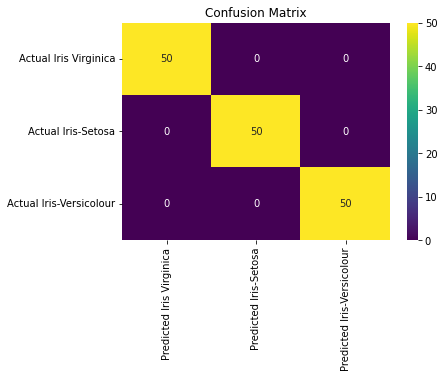

In [ ]:
#2.1.1.: Train Only: modelo de classificação sem split TT

%matplotlib inline


def kNN_train(x, y):
    kNN_classifier_1 = kNN(x, y, 1) #for k = 1
    y_pred = kNN_classifier_1.predict(x)
    #Avaliação do modelo face aos dados de treino
    plot_confusion_matrix(y_pred, y)
    metricas(y_pred, y)
    #Métrica extra: Avaliação do modelo de classificação
    #kNN_score = kNN_classifier_1.score(x_train, y_train)
    #print("Classifier Score: ", kNN_score)
    

kNN_train(x_iris, y_iris)


##2.1.1 Train-Test: modelo de classificação com split TT (70/30)%

Recall/Sensitivity Score:  0.9111111111111111 

Precision Score:  0.9111111111111111 

F1 Score:  0.9111111111111111 

Classifier Score:  0.9111111111111111


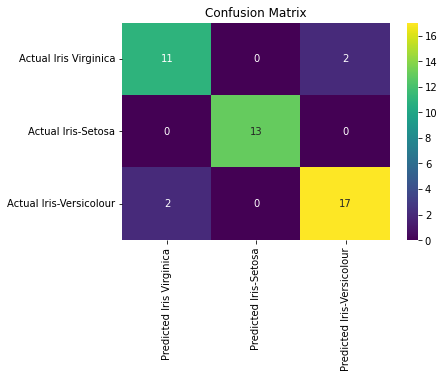

In [ ]:
#2.1.1.: Train-Test: modelo de classificação com split TT (70/30)%
def kNN_train_test(x,y,test_size):
    x_train,x_test,y_test,y_train = Train_Test(x,y,test_size)
    
    kNN_classifier_1 = kNN(x_train, y_train, 1) #for k = 1
    y_pred = kNN_classifier_1.predict(x_test) #predict com x_test 
    
    #Avaliação do modelo face aos dados de treino
    plot_confusion_matrix(y_test, y_pred) #real/test vs pred
    metricas(y_pred, y_test) #parâmetro real será y_test
    #Métrica extra: Avaliação do modelo de classificação
    kNN_score = kNN_classifier_1.score(x_test, y_test)
    print("Classifier Score: ", kNN_score)
    
kNN_train_test(x_iris, y_iris, 0.3) #70% train e 30% test

## 2.1.1 Train-Test: 10*10-fold cross validation (10CV)

In [ ]:
#Função com classificador KNN, com data split train/test utilizando 10*10 CV (c/K-Fold)

def  kNN_TT_Fold(x,y, order, k=1, plot=False):
    recall_aux = []
    precision_aux = []
    f1_aux = []

    for j in range(0, order, 1):  

      kf = KFold(n_splits = order, shuffle = True)

      for i, (train_index, test_index) in enumerate(kf.split(x)):
         #print(f"Fold {i}:")
         #print(f" Test:  index={test_index}")
         x_train = x[train_index]
         #print(len(x_train))
         y_train = y[train_index]
         x_test = x[test_index]
         #print(len(x_test))
         y_test = y[test_index]

         #print('----------------')
         #print(x_train)
         #print(y_train)
         #print(x_test)
         #print(y_test)

         kNN_classifier_1 = kNN(x_train,y_train, k) #for k = 1
         y_pred = kNN_classifier_1.predict(x_test)   
         y_pred = np.array(y_pred).reshape(-1,1) #para separar em vários, ficar como y_test
         #print(y_pred)

         binarizer = MultiLabelBinarizer()

         # This should be your original approach
         #binarizer.fit(your actual true output consisting of all labels)

         #In this case, I am considering only the given labels.
         binarizer.fit(y_test)

         f1 = f1_score(binarizer.transform(y_test), binarizer.transform(y_pred), average='weighted')
         precision = precision_score(binarizer.transform(y_test), binarizer.transform(y_pred), average='weighted')
         recall = recall_score(binarizer.transform(y_test), binarizer.transform(y_pred), average='weighted')

         #y_test_new = binarizer.transform(y_test)
         #y_pred_new = binarizer.transform(y_pred)

         #recall, precision, f1 = metricas(y_test_new, y_pred_new, False)
         recall_aux.append(recall)
         precision_aux.append(precision)
         f1_aux.append(f1)  
         
         if plot == True:
             plt.figure()
             print(f"Fold {i}:")

             plot_confusion_matrix(y_test, y_pred)
             plt.show(block = True) #obriga a desenhar primeiro antes do prox loop

    return recall_aux , precision_aux,  f1_aux #Vai retornar 100 resultados*3

recall, precision, f1 = kNN_TT_Fold(x_iris,y_iris, 10)
df = pd.DataFrame()
df['f1'] = f1
df['precision'] = precision
df['recall'] = recall

#Resultados finais (média das 100 métricas)
results = df[['f1','precision','recall']].mean()
results.to_frame()
print(results)

f1           0.958451
precision    0.964293
recall       0.958667
dtype: float64


## 2.1.2 Train Only: modelo de classificação sem split TT (k vizinhos a variar)

0.9775022506252227
Classifier Score:  [1.0, 0.96, 0.9666666666666667, 0.9733333333333334, 0.98, 0.9733333333333334, 0.98, 0.9866666666666667]


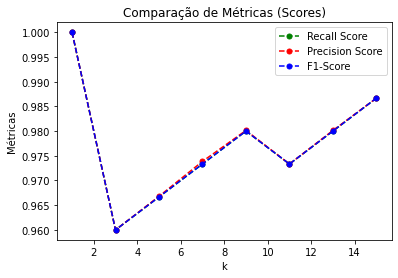

Average f1-score: 0.9775022506252227
Train-Only - Best value of k: k = 1 for f1-score = 1.0


In [ ]:
#Função com classificador KNN, sem data split (apenas utilizando dados de treino), com k neighbours a variar

def kNN_Train_v(x,y, plot = False ):
    
  x_train = x
  y_train = y
  
  kNN_score = []
  recall_scores = []
  precision_scores = []
  f1_scores = []
  K = [1,3,5,7,9,11,13,15]
  
  for k in K:
    kNN_classifier_1 = kNN(x_train, y_train, k) 
    y_pred = kNN_classifier_1.predict(x_train) #predict com x_validation 

    #Avaliação do modelo face aos dados de treino
    #recall, precision, f1 = metricas(y_pred, y_train, False) #parâmetro real será y_test
    recall = recall_score(y_pred, y_train, average = 'weighted')
    precision = precision_score(y_pred, y_train, average = 'weighted')
    f1 = f1_score(y_pred, y_train, average = 'weighted')
    recall_scores.append(recall)
    precision_scores.append(precision)
    f1_scores.append(f1)
    
    #Métrica extra: Avaliação do modelo de classificação
    kNN_score.append(kNN_classifier_1.score(x_train, y_train))
  print(np.mean(f1_scores))
  print("Classifier Score: ", kNN_score)
  if plot == True:   
    plt.plot(K, recall_scores, 'go--', label="Recall Score", markersize = 5)
    #plt.scatter(K, recall_aux)
    plt.plot(K, precision_scores, 'ro--', label="Precision Score", markersize = 5)
    #plt.scatter(K, precision_aux)
    plt.plot(K, f1_scores, 'bo--', label="F1-Score", markersize = 5)
    #plt.scatter(K, f1_aux)
    plt.title("Comparação de Métricas (Scores)")
    plt.xlabel("k")
    plt.ylabel("Métricas")
    plt.legend()
    plt.show()
  print(f"Average f1-score: {np.mean(f1_scores)}")
  print(f'Train-Only - Best value of k: k = {K[np.argmax(np.array(f1_scores))]} for f1-score = {np.array(f1_scores)[np.argmax(np.array(f1_scores))]}')
  
kNN_Train_v(x_iris, y_iris,True) 


## 2.1.2 Train_validation_Test: modelo de classificação com split TVT (40/30/30) (k vizinhos a variar)


#################################################

Recall/Sensitivity Score:  0.9555555555555556 

Precision Score:  0.9555555555555556 

F1 Score:  0.9555555555555556 


#################################################

Recall/Sensitivity Score:  1.0 

Precision Score:  1.0 

F1 Score:  1.0 


#################################################

Recall/Sensitivity Score:  0.9777777777777777 

Precision Score:  0.9791666666666666 

F1 Score:  0.9777777777777777 


#################################################

Recall/Sensitivity Score:  0.9777777777777777 

Precision Score:  0.9791666666666666 

F1 Score:  0.9777777777777777 


#################################################

Recall/Sensitivity Score:  0.9555555555555556 

Precision Score:  0.9555555555555556 

F1 Score:  0.9555555555555556 


#################################################

Recall/Sensitivity Score:  0.9777777777777777 

Precision Score:  0.9791666666666666 

F1 Score:  0.9777777777777777 


##################

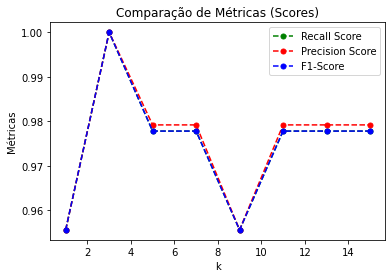

Average f1-score: 0.9750000000000001
Recall/Sensitivity Score:  0.9777777777777777 

Precision Score:  0.9790849673202615 

F1 Score:  0.9775296827928407 



Best k = 3; Best f1_score = 0.9775296827928407



In [ ]:

def kNN_TVT_v_bem(x,y,test_size,validation_size):
  x_train, x_validation, x_test, y_train, y_validation, y_test = Train_Validation_Test(x, y, test_size, validation_size)

  kNN_score = []
  recall_scores = []
  precision_scores = []
  f1_scores = []
  modelos =  []
  K = [1,3,5,7,9,11,13,15]

  for k in K:
    kNN_classifier_1 = kNN(x_train, y_train, k) 
    y_pred = kNN_classifier_1.predict(x_validation) #predict com x_validation 
    print("\n#################################################\n")
    #Avaliação do modelo face aos dados de treino
    #plot_confusion_matrix(y_test, y_pred) #real/test vs pred

    recall, precision, f1 = metricas(y_pred, y_validation) #parâmetro real será y_test
    recall_scores.append(recall)
    precision_scores.append(precision)
    f1_scores.append(f1)
    modelos.append(kNN_classifier_1)
    #Métrica extra: Avaliação do modelo de classificação
    kNN_score.append(kNN_classifier_1.score(x_test, y_test))


  plt.plot(K, recall_scores, 'go--', label="Recall Score", markersize = 5)
  #plt.scatter(K, recall_aux)
  plt.plot(K, precision_scores, 'ro--', label="Precision Score", markersize = 5)
  #plt.scatter(K, precision_aux)
  plt.plot(K, f1_scores, 'bo--', label="F1-Score", markersize = 5)
  #plt.scatter(K, f1_aux)
  plt.title("Comparação de Métricas (Scores)")
  plt.xlabel("k")
  plt.ylabel("Métricas")
  plt.legend()
  plt.show()
  print(f"Average f1-score: {np.mean(f1_scores)}")
  #print(f'Train-Only - Best value of k: k = {K[np.argmax(np.array(f1_scores))]} for f1-score = {np.array(f1_scores)[np.argmax(np.array(f1_scores))]}')

  best_f1_index = np.argmax(f1_scores)
  best_k = K[best_f1_index]
  kNN_classifier_1 = kNN(np.concatenate((x_train,x_validation)), np.concatenate((y_train,y_validation)), best_k) 
  y_pred = kNN_classifier_1.predict(x_test)
  recall, precision, f1 = metricas(y_pred, y_test)

  print(f'\n\nBest k = {best_k}; Best f1_score = {f1}\n')


kNN_TVT_v_bem(x_iris, y_iris, 0.3, 0.3) #40% train e 30% validation e 30% test




#################################################

Recall/Sensitivity Score:  0.9333333333333333 

Precision Score:  0.9337403337403338 

F1 Score:  0.9329117735621801 


#################################################

Recall/Sensitivity Score:  0.9555555555555556 

Precision Score:  0.9597883597883597 

F1 Score:  0.9550793650793651 


#################################################

Recall/Sensitivity Score:  0.9333333333333333 

Precision Score:  0.9337403337403338 

F1 Score:  0.9329117735621801 


#################################################

Recall/Sensitivity Score:  0.9777777777777777 

Precision Score:  0.978835978835979 

F1 Score:  0.9776372578540601 


#################################################

Recall/Sensitivity Score:  0.9333333333333333 

Precision Score:  0.9337403337403338 

F1 Score:  0.9329117735621801 


#################################################

Recall/Sensitivity Score:  0.9777777777777777 

Precision Score:  0.978835978835979 

F1 Score

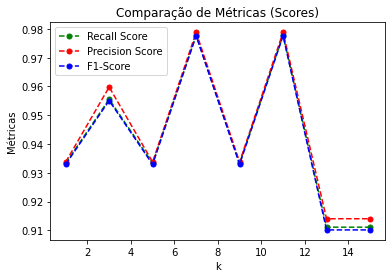

Average f1-score: 0.9411758327239358


In [ ]:
#Função com classificador KNN, com data split Train-Validation-Test(40% dados de treino, 30% teste,30% validaçao), com k neighbours a variar

def kNN_TVT_v(x,y,test_size,validation_size, plot = True):
    x_train, x_validation, x_test, y_train, y_validation, y_test = Train_Validation_Test(x, y, test_size, validation_size)
    
    kNN_score = []
    recall_scores = []
    precision_scores = []
    f1_scores = []
    modelos =  []
    K = [1,3,5,7,9,11,13,15]
    
    for k in K:
        kNN_classifier_1 = kNN(x_train, y_train, k) 
        y_pred = kNN_classifier_1.predict(x_validation) #predict com x_validation 
        print("\n#################################################\n")
        #Avaliação do modelo face aos dados de treino
        #plot_confusion_matrix(y_test, y_pred) #real/test vs pred

        recall, precision, f1 = metricas(y_pred, y_validation) #parâmetro real será y_test
        recall_scores.append(recall)
        precision_scores.append(precision)
        f1_scores.append(f1)
        
        #Métrica extra: Avaliação do modelo de classificação
        kNN_score.append(kNN_classifier_1.score(x_test, y_test))
       # print("Classifier Score: ", kNN_score)
    if plot == True:     
      plt.plot(K, recall_scores, 'go--', label="Recall Score", markersize = 5)
      #plt.scatter(K, recall_aux)
      plt.plot(K, precision_scores, 'ro--', label="Precision Score", markersize = 5)
      #plt.scatter(K, precision_aux)
      plt.plot(K, f1_scores, 'bo--', label="F1-Score", markersize = 5)
      #plt.scatter(K, f1_aux)
      plt.title("Comparação de Métricas (Scores)")
      plt.xlabel("k")
      plt.ylabel("Métricas")
      plt.legend()
      plt.show()
    print(f"Average f1-score: {np.mean(f1_scores)}")
    #print(f'Train-Validation-Test - Best value of k: k = {K[np.argmax(np.array(f1_scores))]} for f1-score = {np.array(f1_scores)[np.max(np.array(f1_scores))]}')
    return f1_scores,precision_scores,recall_scores
f1_scores,precision_scores,recall_scores = kNN_TVT_v(x_iris, y_iris, 0.3, 0.3) #40% train e 30% validation e 30% test



##2.1.2: Train-Test: 10*10-fold cross validation (10CV) (k vizinhos a variar)

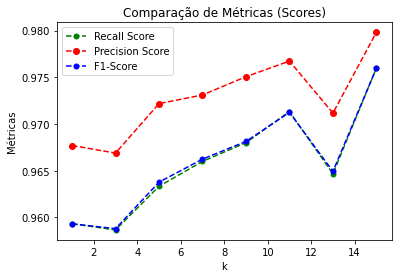

Aaverage f1_score 0.9660523180294077
O melhor valor de k é 15 com f1-score = 0.9759743759508465


In [ ]:


def CV10_TT_KNN(x,y, plot = True):

  #Classificador KNN, com data split train/test utilizando 10*10 CV (c/K-Fold), com k neighbours a variar

  #Igual ao 2.1.1. 10*10, k vizinhos variam
  K = [1,3,5,7,9,11,13,15]

  #Resultados para cada k (8 médias finais)
  r_f = pd.DataFrame(columns = ['f1','precision','recall'])
  for i in K:
      recall, precision, f1 = kNN_TT_Fold(x, y, 10, i, False)
      
      df = pd.DataFrame()
      df['f1'] = f1
      df['precision'] = precision
      df['recall'] = recall

      #Resultados finais (média das 100 métricas)
      results = df.mean()
      #results.transpose()
      r_f.loc[len(r_f)] = results
  if plot == True:      
    plt.plot(K, r_f['recall'], 'go--', label="Recall Score", markersize = 5)
    #plt.scatter(K, r_f['recall'])
    plt.plot(K, r_f['precision'],'ro--',label="Precision Score")
    #plt.scatter(K, r_f['precision'])
    plt.plot(K, r_f['f1'], 'bo--', label="F1-Score", markersize = 5)
    #plt.scatter(K, r_f['f1'])
        
    plt.title("Comparação de Métricas (Scores)")
    plt.xlabel("k")
    plt.ylabel("Métricas")
    plt.legend()
    plt.show()
  mean = r_f['f1'].mean()
  print(f'Aaverage f1_score {mean}')
  print(f"O melhor valor de k é {K[np.argmax(r_f['f1'])]} com f1-score = {r_f['f1'][np.argmax(r_f['f1'])]}")
  return r_f['f1'],r_f['precision'],r_f['recall']

        
  #Resultados Finais (depois de tuning com validation, prever com o teste)
  best_classifier = kNN(x_train,y_train), K[np.argmax(r_f['f1'])]) 
  y_pred = kNN_classifier_1.predict(x_test)
  recall, precision, f1 = metricas(y_pred, y_test)
  plot_confusion_matrix(y_test, y_pred)

f1_scores,precision_scores,recall_scores  = CV10_TT_KNN(x_iris,y_iris, True)

##2.1.3  Análise de resultados kNN (começou a bugar)

In [ ]:
def average_result(xx,yy,model):                   #iterar varias veze so modelo para obter uam estimativa media  (apenas par ao 2.2.3)
  f1_all =[]
  ks = [i for i in range(1, 16, 2)]
  f1_all = np.array([0,0,0,0,0,0,0,0]) 
  precision_all = np.array([0,0,0,0,0,0,0,0]) 
  recall_all = np.array([0,0,0,0,0,0,0,0]) 

  for i in range(15):
    #print()
    if model == "cross":
      f1,precision, recall = CV10_TT_KNN(xx, yy, False)
    if model == "tvt":
      f1,precision, recall = kNN_TVT_v(xx, yy, 0.3, 0.3, False)
    print("###############\n")
    f1_all = f1_all + f1
    precision_all = precision_all + precision
    recall_all = recall_all + recall

  f1_all = f1_all/15
  precision_all = precision_all/15
  recall_all = recall_all/15

  plt.plot(ks, f1_all, label = "f1" )
  plt.scatter(ks, f1_all)

  plt.plot(ks, precision_all, label = "precision" )
  plt.scatter(ks, precision_all)

  plt.plot(ks, recall_all, label = "recall" )
  plt.scatter(ks, recall_all)
  plt.legend()
  plt.xlabel('k')
  plt.ylabel('f1-score')
  plt.show()
  return f1_all



## Media de Resulatdos cross Validation(k vizinhos a variar)



Aaverage f1_score 0.9658455618455617
O melhor valor de k é 15 com f1-score = 0.9707285270285269
###############

Aaverage f1_score 0.9652938940066068
O melhor valor de k é 15 com f1-score = 0.9722170326405621
###############

Aaverage f1_score 0.9654465218375823
O melhor valor de k é 13 com f1-score = 0.9694828733014492
###############

Aaverage f1_score 0.9686220545393145
O melhor valor de k é 11 com f1-score = 0.9765838531494877
###############

Aaverage f1_score 0.9654954486546592
O melhor valor de k é 7 com f1-score = 0.9701485116534652
###############

Aaverage f1_score 0.9657476357936345
O melhor valor de k é 11 com f1-score = 0.9717624915676
###############

Aaverage f1_score 0.96555916500009
O melhor valor de k é 15 com f1-score = 0.9727046181888287
###############

Aaverage f1_score 0.9656402239193841
O melhor valor de k é 13 com f1-score = 0.9714162408741355
###############

Aaverage f1_score 0.9661821112574789
O melhor valor de k é 15 com f1-score = 0.9701657808422515
######

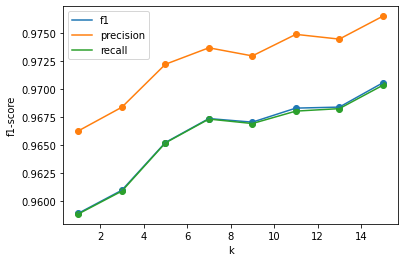

In [ ]:
f1 = average_result(x_iris,y_iris,"cross")

## Media de Resulatdos Train Validation Test (k vizinhos a variar)



#################################################

Recall/Sensitivity Score:  0.9777777777777777 

Precision Score:  0.9793650793650793 

F1 Score:  0.9778718400940623 


#################################################

Recall/Sensitivity Score:  0.9333333333333333 

Precision Score:  0.9343604108309991 

F1 Score:  0.9331940090560781 


#################################################

Recall/Sensitivity Score:  0.9777777777777777 

Precision Score:  0.9793650793650793 

F1 Score:  0.9778718400940623 


#################################################

Recall/Sensitivity Score:  0.9111111111111111 

Precision Score:  0.9157796451914098 

F1 Score:  0.9109259259259259 


#################################################

Recall/Sensitivity Score:  0.9333333333333333 

Precision Score:  0.9343604108309991 

F1 Score:  0.9331940090560781 


#################################################

Recall/Sensitivity Score:  0.9111111111111111 

Precision Score:  0.9157796451914098 

F1 Sco

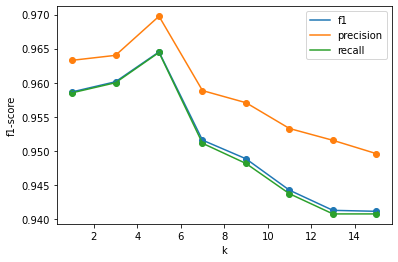

In [ ]:
f1 = average_result(x_iris,y_iris,"tvt")

 Podemos então concluir que para **k demasiados baixos** temos **underfitting** e para **k demasiado altos** temos **overfitting**

#2.2

In [99]:
# Implementação do ReliefF para retornar os índices e não os nomes, como na implementação acima

from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
# Carregar os dados do dataset "Iris" e respetiva separação dos mesmos
iris = datasets.load_iris()
x_data = iris["data"]
y_data = iris["target"]

def k_neighbors(x, y, k):
  neigh = KNeighborsClassifier(n_neighbors=k)
  neigh.fit(x, y)
  return neigh

def plt_feature(df):
  df = df.T
  for i in df.keys():
    plt.plot(df[i], label = i)
  #plt.ylim(0.8, 1.1)
  plt.title("f1 score in order k for different #features")
  plt.xlabel("k")
  plt.ylabel("f1_score")
  plt.legend()
  plt.show()

def plt_ks(df):
  for i in df.keys():
    plt.plot(df[i], label = i)
    plt.title("f1 score in order of # features for different k")
    plt.xlabel("number of feature")
    plt.ylabel("f1_score")
    plt.axis(xlim=(0, 1), ylim=(0, 1))
    plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
    #plt.ylim(0.8, 1.1)
    plt.legend()
  plt.show()

def plt_best_k(df):
  indices = df.index
  df_t = df.T
  aux = []
  n   = []
  for i in indices:
    aux.append(max(df_t[i]))
    n.append(f'Best k: {df.keys()[np.argmax(df_t[i])]}')
  plt.scatter(indices, aux)
  plt.ylabel('f1_score')
  plt.xlabel('feature')
  plt.title('best value of f1_score for each feature')
  plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
  #plt.ylim(0.8, 1.1)
  for i, txt in enumerate(n):
    plt.annotate(txt, (indices[i], aux[i]))
  plt.show()


def main_2_2_TVT(x, y, sorted_features, plot = True):



  # Initialize Variables
  list_of_multiple_features = [sorted_features[:i] for i in range(1, 1 + len(sorted_features))]
  ks = [i for i in range(1, 16, 2)]
  features_to_include = []

  f1_score_features = []

  all_models = []


  x_train, x_validation, x_test, y_train, y_validation, y_test = Train_Validation_Test(x,y,0.3,0.3)

  #x_train,x_test,y_test,y_train = Train_Test(x,y,0.3)
  labels_nr_features = [str(i) + " features" for i in range(1, len(sorted_features) + 1)]
  list_of_multiple_features = [sorted_features[:i] for i in range(1, 1 + len(sorted_features))]
  for feat in sorted_features:
      features_to_include.append(feat)
      X_train = x_train[:, features_to_include]
      X_validate = x_test[:, features_to_include]
      f1_score_for_this_features = []
      
      for k in ks:
          model = k_neighbors(X_train,y_train, k)
          pred = model.predict(X_validate)
          #recall, precision, f1 = metricas(pred, y_test, False)

          recall = recall_score(y_test, pred, average = 'weighted')
          precision = precision_score(y_test, pred, average = 'weighted')
          f1 = f1_score(y_test, pred, average = 'weighted')

          f1_score_for_this_features.append(f1)
      f1_score_features.append(f1_score_for_this_features)
  results = pd.DataFrame(f1_score_features, columns=ks, index=labels_nr_features)
  
  if plot == True:
    plt_ks(results)
    plt_best_k(results)
    plt_feature(results)

  k_best = ks[np.argmax(pd.DataFrame(f1_score_features).mean())]

  print(f'best k = {k_best}  ')

  best_classifier = kNN(np.concatenate((x_train,x_validation)), np.concatenate((y_train,y_validation)), k_best) 
  y_pred = best_classifier.predict(x_test)
  recall, precision, f1 = metricas(y_pred, y_test)
  plot_confusion_matrix(y_test, y_pred) 

  return  results




In [ ]:



def main_2_2(x, y, sorted_features, plot = True):



  # Initialize Variables
  list_of_multiple_features = [sorted_features[:i] for i in range(1, 1 + len(sorted_features))]
  ks = [i for i in range(1, 16, 2)]
  features_to_include = []

  f1_score_features = []

  all_models = []


  #x_train, x_validation, x_test, y_train, y_validation, y_test = Train_Validation_Test(x,y,0.3,0.3)

  x_train,x_test,y_test,y_train = Train_Test(x,y,0.3)
  labels_nr_features = [str(i) + " features" for i in range(1, len(sorted_features) + 1)]
  list_of_multiple_features = [sorted_features[:i] for i in range(1, 1 + len(sorted_features))]
  for feat in sorted_features:
      features_to_include.append(feat)
      X_train = x_train[:, features_to_include]
      X_validate = x_test[:, features_to_include]
      f1_score_for_this_features = []
      
      for k in ks:
          model = k_neighbors(X_train,y_train, k)
          pred = model.predict(X_validate)
          #recall, precision, f1 = metricas(pred, y_test, False)

          recall = recall_score(y_test, pred, average = 'weighted')
          precision = precision_score(y_test, pred, average = 'weighted')
          f1 = f1_score(y_test, pred, average = 'weighted')

          f1_score_for_this_features.append(f1)
      f1_score_features.append(f1_score_for_this_features)
  results = pd.DataFrame(f1_score_features, columns=ks, index=labels_nr_features)
  
  if plot == True:
    plt_ks(results)
    plt_best_k(results)
    plt_feature(results)

  return  results



##ReliefF

In [ ]:
pip install reliefF

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48 kB 3.3 MB/s 
  Created wheel for reliefF: filename=ReliefF-0.1.2-py3-none-any.whl size=6318 sha256=e56673b6bb4ed061bd8c6660ae533a60a42a1cbb654f78bc7ff7367a0ec0eb3c
  Stored in directory: /root/.cache/pip/wheels/d8/90/ef/7691706c1c418d2c266a0b3b06371900f4b86e74223912c563
Successfully built reliefF


array([3, 2, 0, 1])

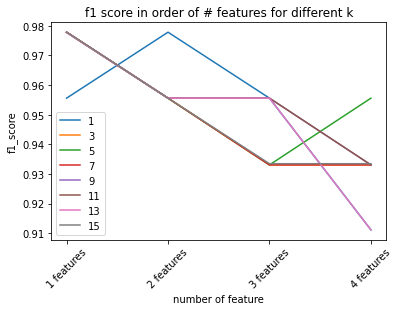

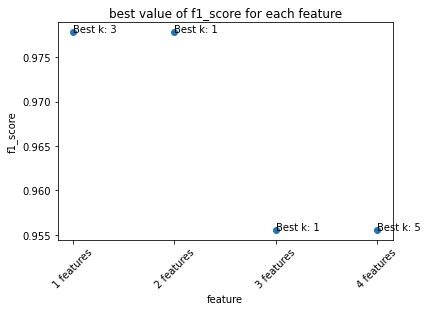

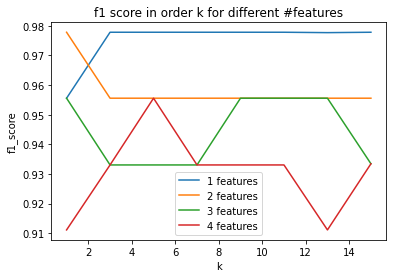

best k = 5  
Recall/Sensitivity Score:  0.9333333333333333 

Precision Score:  0.9354497354497354 

F1 Score:  0.9336331834082958 



,1,3,5,7,9,11,13,15
1 features,0.955556,0.977811,0.977811,0.977811,0.977811,0.977811,0.977678,0.977811
2 features,0.977811,0.955556,0.955556,0.955556,0.955556,0.955556,0.955556,0.955556
3 features,0.955556,0.933033,0.933033,0.933033,0.955556,0.955556,0.955556,0.933432
4 features,0.911111,0.933033,0.955556,0.933033,0.933033,0.933033,0.911111,0.933432


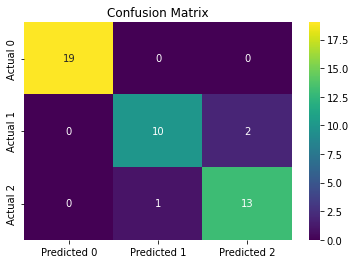

In [ ]:
from ReliefF import ReliefF 

def main_relief(x,y,n_neighbors=100, n_features_to_keep=4, plot = True):

  # Implementação do ReliefF para retornar os índices e não os nomes, como na implementação acima
  # Implementação do KNN com k vizinhos

  fs = ReliefF(n_neighbors, n_features_to_keep)
  fs.fit_transform(x, y)
  display(fs)
  sorted_features = fs.top_features[:n_features_to_keep]   #tava aqui 10

  display(sorted_features)

  df = main_2_2_TVT(x,y, sorted_features,plot)


  df.style.set_table_attributes("style='display:inline'").set_caption('f1  metric in order to k and number of features')

  return df
main_relief(iris['data'], iris['target'],100, 4)

In [ ]:
df.mean().mean()

0.9604702336401512

não se pode tirar conclusões sobre overfiting e underfiting porque os valores
de f1 score são todos elevado, muito proximos de 1 independentemente  do valor de k e do número de features a usar

#2.3   


## Forward feature Selection

https://towardsdatascience.com/feature-importance-and-forward-feature-selection-752638849962



 -  **forward feature selection**. This reduction in features offers the following benefits;


  1. Reduced training times
  2. Simplified and interpretable models
  3. Reduced chances of overfitting i.e. lesser variance
  4. Less impact of the curse of dimensionality
  
  


[3, 0, 2, 1]


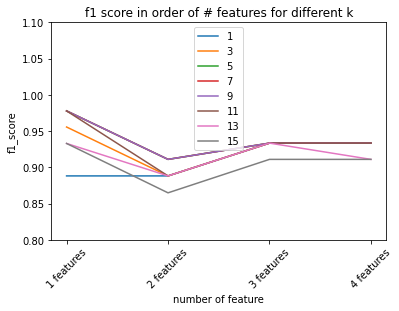

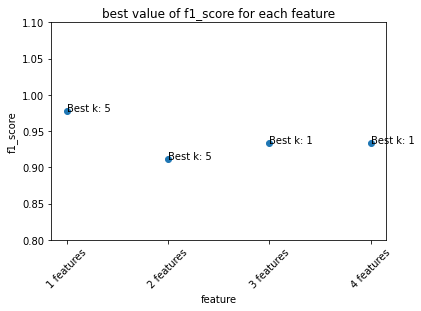

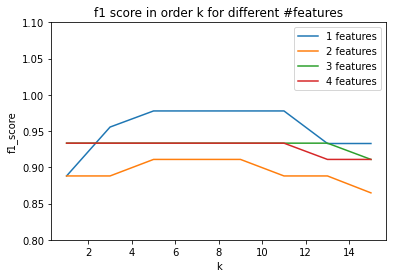

best k = 5  
Recall/Sensitivity Score:  0.9333333333333333 

Precision Score:  0.9347089947089947 

F1 Score:  0.9333333333333333 



,1,3,5,7,9,11,13,15
1 features,0.888092,0.955556,0.977778,0.977778,0.977778,0.977778,0.932855,0.932855
2 features,0.888092,0.888092,0.910899,0.910899,0.910899,0.888092,0.888092,0.864744
3 features,0.933333,0.933333,0.933333,0.933333,0.933333,0.933333,0.933333,0.910899
4 features,0.933333,0.933333,0.933333,0.933333,0.933333,0.933333,0.910899,0.910899


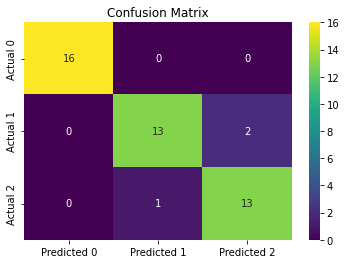

In [ ]:


# Carregar os dados do dataset "Iris" e respetiva separação dos mesmos
iris = datasets.load_iris()
x_iris = iris["data"]
y_iris = iris["target"]

def forward_feature_selection(x,y ,n):
  x_train,x_test,y_test,y_train = Train_Test(x,y,0.3)
  feature_set = []
  for num_features in range(n):
    metric_list = [] # Choose appropriate metric based on business problem
    model = SGDClassifier() # You can choose any model you like, this technique is model agnostic
    for feature in pd.DataFrame(x_train).columns:
      if feature not in feature_set:
        f_set = feature_set.copy()

        f_set.append(feature)
        model.fit(pd.DataFrame(x_train)[f_set], pd.DataFrame(y_train))


        pred = model.predict(pd.DataFrame(x_test)[f_set])
        #recall, precision, f1 = metricas(pred, y_test, False)

        recall = recall_score(y_test, pred, average = 'weighted')
        precision = precision_score(y_test, pred, average = 'weighted')
        f1 = f1_score(y_test, pred, average = 'weighted')

        metric_list.append((f1,feature))

    metric_list.sort(key=lambda x : x[0], reverse = True) # In case metric follows "the more, the merrier"
    feature_set.append(metric_list[0][1])
  return feature_set

def main_forward(x,y ,n, plot= True):
  sorted_features = forward_feature_selection(x,y,n)
  print(sorted_features)
  df = main_2_2_TVT(x,y, sorted_features, plot)
  return df


df = main_forward(x_iris,y_iris,4)
df.style.set_table_attributes("style='display:inline'").set_caption('f1  metric in order to k and number of features')




In [ ]:
df.mean().mean()

0.9722460947549184

## Fisher score

- Fisher score: Typically used in binary classification problems, the Fisher ration (FiR) is defined as the distance between the sample means for each class per feature divided by their variances:
$$
\operatorname{FiR}_i=\frac{\left|\bar{X}_i^{(0)}-\bar{X}_i^{(1)}\right|}{\sqrt{\operatorname{var}\left(X_i\right)^{(0)}+\operatorname{Var}\left(X_i\right)^{(1)}}}
$$


Biblioteca ; https://github.com/jundongl/scikit-feature/blob/master/skfeature/function/similarity_based/fisher_score.py

In [ ]:
pip install skfeature-chappers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 66 kB 2.8 MB/s 


[1 0 3 2]


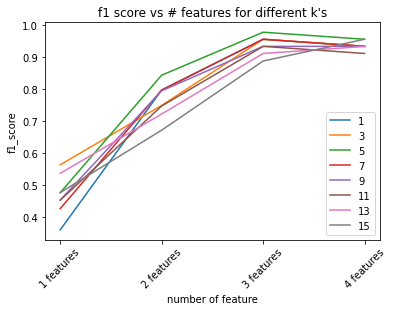

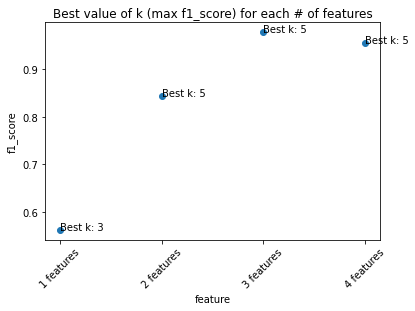

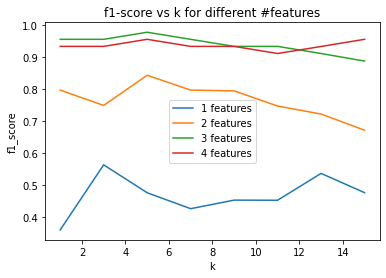

best k = 5  
Recall/Sensitivity Score:  1.0 

Precision Score:  1.0 

F1 Score:  1.0 



,1,3,5,7,9,11,13,15
1 features,0.358718,0.562457,0.475109,0.425201,0.452003,0.451613,0.535740,0.475341
2 features,0.796571,0.748479,0.843040,0.796571,0.794115,0.746586,0.721549,0.670899
3 features,0.955556,0.955556,0.977703,0.955556,0.933407,0.933407,0.911111,0.887455
4 features,0.933407,0.933407,0.955556,0.933407,0.933407,0.911111,0.933109,0.955556


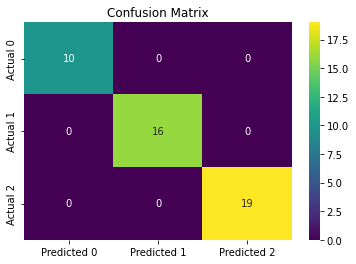

In [ ]:
from skfeature.function.similarity_based import fisher_score 

%matplotlib inline 
# Calculating scores

def main_fisher(x,y, number_of_elements, plot = True):
  fisher = fisher_score.fisher_score(x,y)[0:number_of_elements]
  print(fisher)
  df = main_2_2_TVT(x,y, fisher, plot)
  return df

main_fisher(x_iris,y_iris,4)

In [ ]:
df.mean().mean()

0.9589067212186658

[1 0 3 2]
best k = 11  
Recall/Sensitivity Score:  1.0 

Precision Score:  1.0 

F1 Score:  1.0 

[1 0 3 2]
best k = 3  
Recall/Sensitivity Score:  0.9777777777777777 

Precision Score:  0.9792592592592592 

F1 Score:  0.9778760192553295 



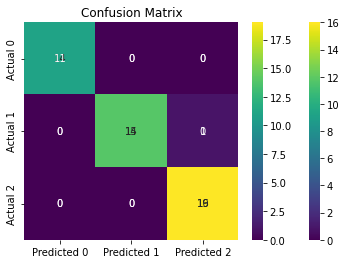

[1 0 3 2]
best k = 7  
Recall/Sensitivity Score:  0.9777777777777777 

Precision Score:  0.9794871794871796 

F1 Score:  0.9779047619047618 



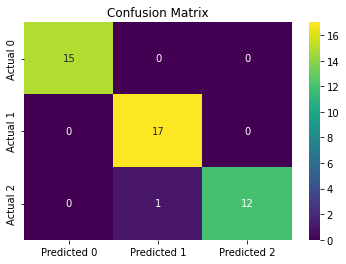

[1 0 3 2]
best k = 15  
Recall/Sensitivity Score:  0.9555555555555556 

Precision Score:  0.960233918128655 

F1 Score:  0.9550807217473883 



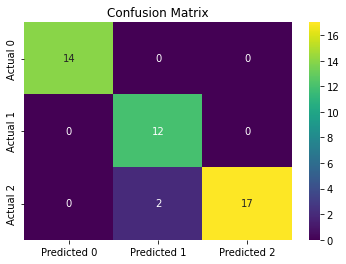

[1 0 3 2]
best k = 7  
Recall/Sensitivity Score:  0.9333333333333333 

Precision Score:  0.943859649122807 

F1 Score:  0.9321904761904761 



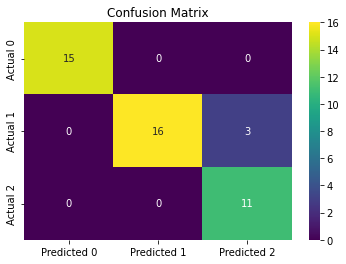

[1 0 3 2]
best k = 1  
Recall/Sensitivity Score:  0.9777777777777777 

Precision Score:  0.9791666666666666 

F1 Score:  0.9777995003801455 



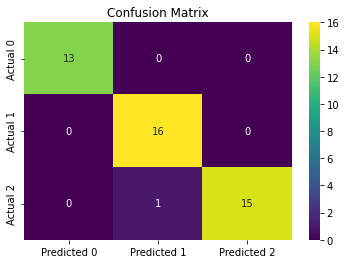

[1 0 3 2]
best k = 9  
Recall/Sensitivity Score:  0.9555555555555556 

Precision Score:  0.9555555555555556 

F1 Score:  0.9555555555555556 



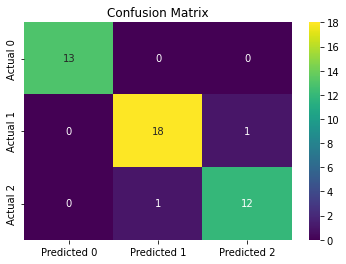

[1 0 3 2]
best k = 9  
Recall/Sensitivity Score:  0.9777777777777777 

Precision Score:  0.9790849673202615 

F1 Score:  0.9777029554807333 



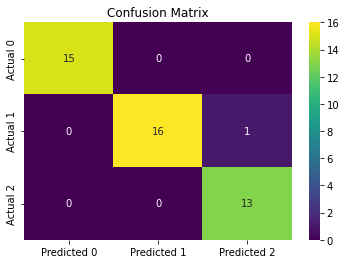

[1 0 3 2]
best k = 11  
Recall/Sensitivity Score:  1.0 

Precision Score:  1.0 

F1 Score:  1.0 



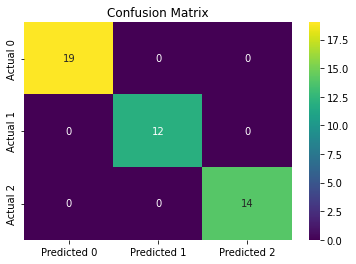

[1 0 3 2]
best k = 7  
Recall/Sensitivity Score:  0.9333333333333333 

Precision Score:  0.9344662309368191 

F1 Score:  0.9332681655262302 



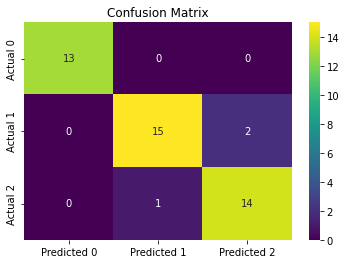

[1 0 3 2]
best k = 3  
Recall/Sensitivity Score:  0.9777777777777777 

Precision Score:  0.9791666666666666 

F1 Score:  0.9777530589543938 



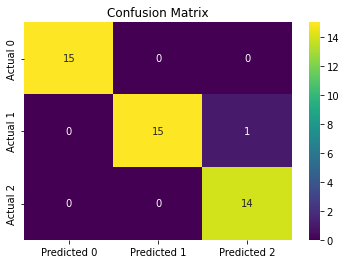

[1 0 3 2]
best k = 3  
Recall/Sensitivity Score:  1.0 

Precision Score:  1.0 

F1 Score:  1.0 



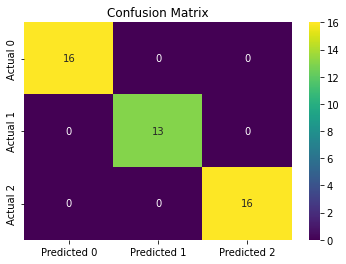

[1 0 3 2]
best k = 5  
Recall/Sensitivity Score:  0.9555555555555556 

Precision Score:  0.9555555555555556 

F1 Score:  0.9555555555555556 



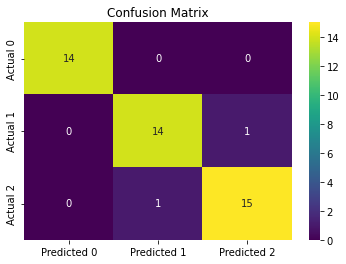

[1 0 3 2]
best k = 9  
Recall/Sensitivity Score:  0.9777777777777777 

Precision Score:  0.9790123456790124 

F1 Score:  0.9776837154614932 



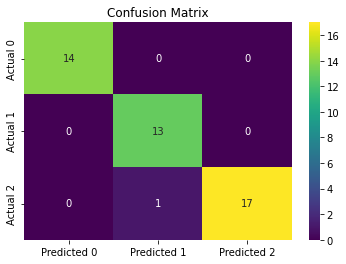

[1 0 3 2]
best k = 13  
Recall/Sensitivity Score:  1.0 

Precision Score:  1.0 

F1 Score:  1.0 



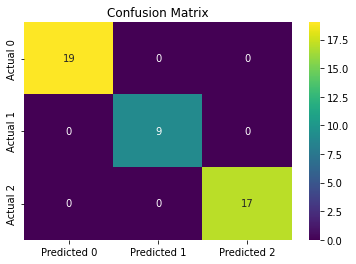

[1 0 3 2]
best k = 1  
Recall/Sensitivity Score:  0.9333333333333333 

Precision Score:  0.9349074074074074 

F1 Score:  0.9334726576105885 



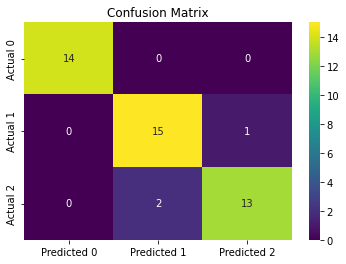

[1 0 3 2]
best k = 13  
Recall/Sensitivity Score:  1.0 

Precision Score:  1.0 

F1 Score:  1.0 



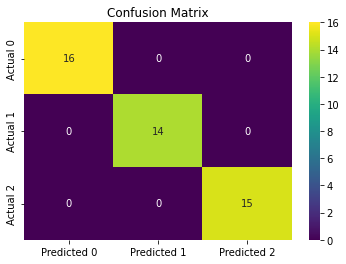

[1 0 3 2]
best k = 1  
Recall/Sensitivity Score:  0.9555555555555556 

Precision Score:  0.9614814814814815 

F1 Score:  0.9558356676003735 



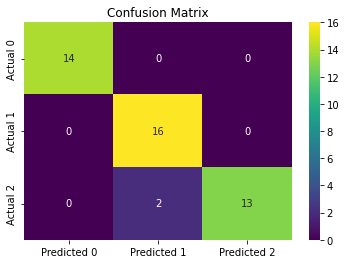

[1 0 3 2]
best k = 11  
Recall/Sensitivity Score:  0.9555555555555556 

Precision Score:  0.9555555555555556 

F1 Score:  0.9555555555555556 



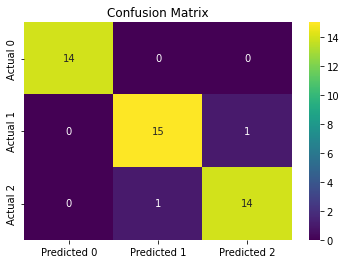

[1 0 3 2]
best k = 1  
Recall/Sensitivity Score:  0.9555555555555556 

Precision Score:  0.9555555555555556 

F1 Score:  0.9555555555555556 



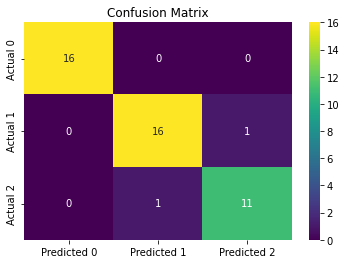

[1 0 3 2]
best k = 9  
Recall/Sensitivity Score:  0.9777777777777777 

Precision Score:  0.9790849673202615 

F1 Score:  0.9777777777777777 



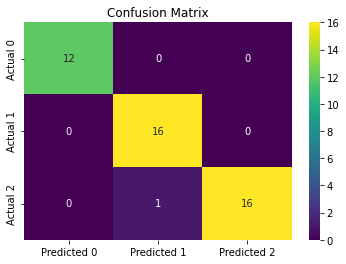

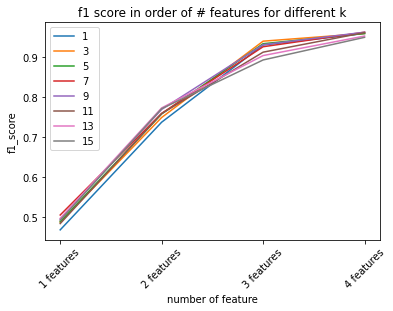

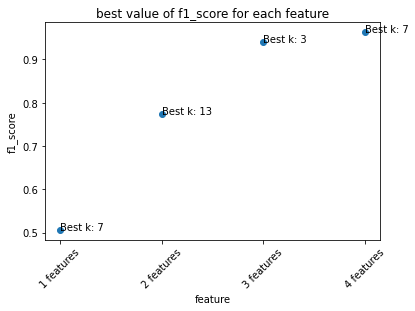

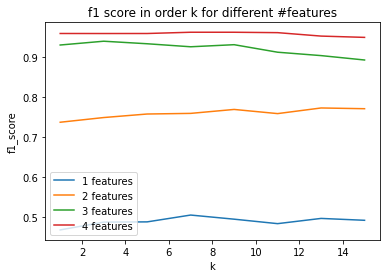

In [ ]:
def fisher_average(x,y,repeat):                   #iterar varias veze so modelo para obter uam estimativa media  (apenas par ao 2.2.3)
  ks = [i for i in range(1, 16, 2)]
  df = main_fisher(x,y,4, False)
  for i in range(repeat):
    df = df + main_fisher(x,y,4, False)
    plt.show()
  df =df/(repeat+1)
  
  plt_ks(df)
  plt_best_k(df)
  plt_feature(df)
  plt.show()
fisher_average(x_data, y_data,20)

Neste caso é possivel observar que o valor de f1_score é dependnete do numero de features com uma correlação positiva, e que para o mesmo numeor de features o valor de k não é significnante para o valor o valor de f1_score

#2.4


In [100]:
from sklearn.linear_model import SGDClassifier

iris = datasets.load_iris()
x_data = iris["data"]
y_data = iris["target"]


iris_df = pd.DataFrame(x_data, columns=iris["feature_names"])
iris_df["Target"] = y_data
Setosa = iris_df[iris_df["Target"] == 0]
Versicolour = iris_df[iris_df["Target"] == 1].sample(n=30)
Virginica = iris_df[iris_df["Target"] == 2].sample(n=10)


iris_2_4 = Setosa.append(Versicolour)
iris_2_4 = iris_2_4.append(Virginica)
iris_2_4.groupby("Target").count()

x_unbalanced = np.array(iris_2_4.drop(columns=["Target"]))
y_unbalanced = np.array(iris_2_4["Target"])

[3, 1, 0, 2]


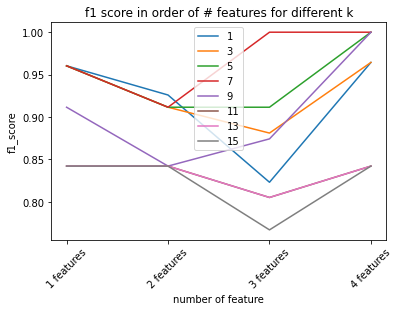

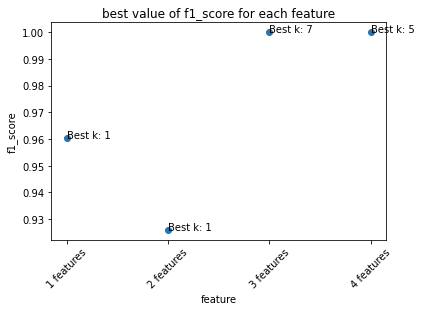

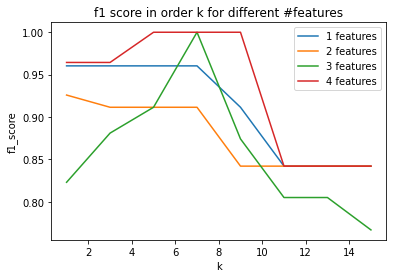

best k = 7  
Recall/Sensitivity Score:  1.0 

Precision Score:  1.0 

F1 Score:  1.0 



,1,3,5,7,9,11,13,15
1 features,0.960349,0.960349,0.960349,0.960349,0.911523,0.842105,0.842105,0.842105
2 features,0.925926,0.911523,0.911523,0.911523,0.842105,0.842105,0.842105,0.842105
3 features,0.823045,0.881046,0.911523,1.000000,0.874200,0.805088,0.805088,0.766885
4 features,0.964374,0.964374,1.000000,1.000000,1.000000,0.842105,0.842105,0.842105


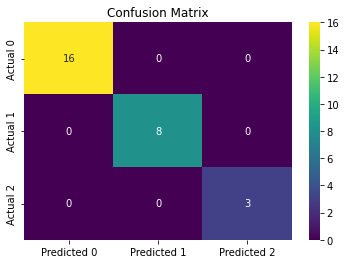

In [101]:
main_forward(x_unbalanced,y_unbalanced ,4, plot= True)

agora fazendo uma media dos testes

[1 0 3 2]
best k = 7  
Recall/Sensitivity Score:  0.9333333333333333 

Precision Score:  0.9348148148148148 

F1 Score:  0.9334074898034853 

[1 0 3 2]
best k = 9  
Recall/Sensitivity Score:  0.9777777777777777 

Precision Score:  0.9793650793650793 

F1 Score:  0.9778526000748223 



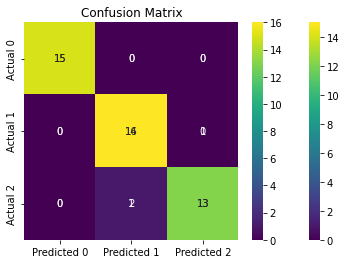

[1 0 3 2]
best k = 5  
Recall/Sensitivity Score:  0.9777777777777777 

Precision Score:  0.9792592592592592 

F1 Score:  0.9778606192399296 



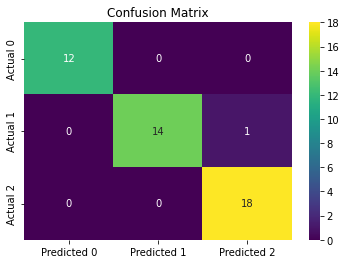

[1 0 3 2]
best k = 15  
Recall/Sensitivity Score:  0.9333333333333333 

Precision Score:  0.9450980392156864 

F1 Score:  0.9331108639228773 



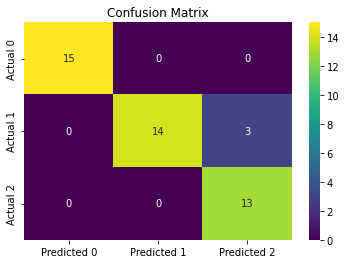

[1 0 3 2]
best k = 15  
Recall/Sensitivity Score:  0.9777777777777777 

Precision Score:  0.9792592592592592 

F1 Score:  0.9778024966011619 



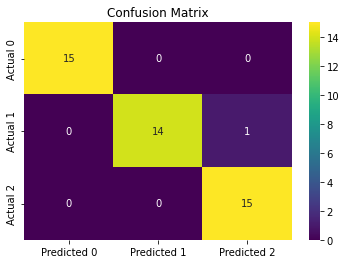

[1 0 3 2]
best k = 9  
Recall/Sensitivity Score:  0.9555555555555556 

Precision Score:  0.9604938271604938 

F1 Score:  0.9551533433886376 



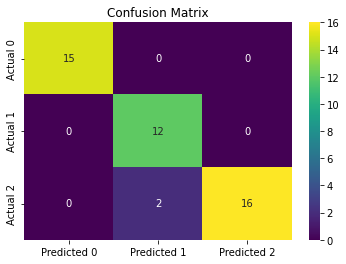

[1 0 3 2]
best k = 7  
Recall/Sensitivity Score:  0.9777777777777777 

Precision Score:  0.9790123456790124 

F1 Score:  0.9776837154614932 



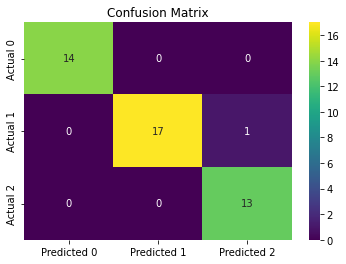

[1 0 3 2]
best k = 9  
Recall/Sensitivity Score:  0.9777777777777777 

Precision Score:  0.9789473684210527 

F1 Score:  0.9777413777413778 



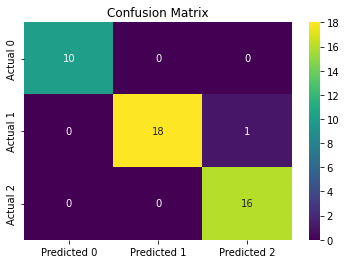

[1 0 3 2]
best k = 5  
Recall/Sensitivity Score:  0.9111111111111111 

Precision Score:  0.9169312169312168 

F1 Score:  0.9111111111111111 



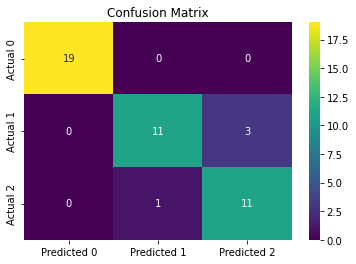

[1 0 3 2]
best k = 5  
Recall/Sensitivity Score:  1.0 

Precision Score:  1.0 

F1 Score:  1.0 



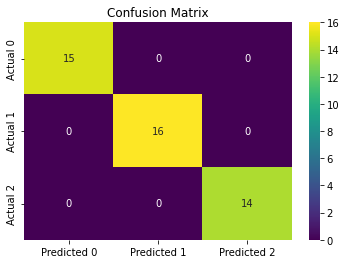

[1 0 3 2]
best k = 1  
Recall/Sensitivity Score:  0.9111111111111111 

Precision Score:  0.9111111111111111 

F1 Score:  0.9111111111111111 



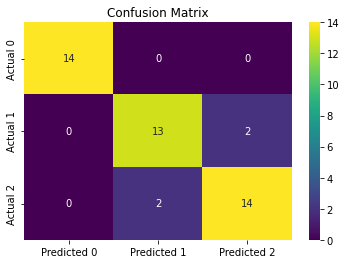

[1 0 3 2]
best k = 5  
Recall/Sensitivity Score:  0.9777777777777777 

Precision Score:  0.9790849673202615 

F1 Score:  0.9777560551754101 



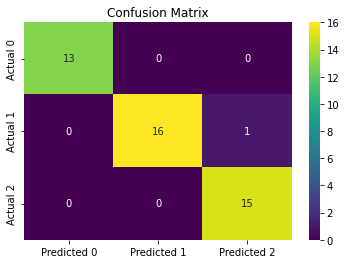

[1 0 3 2]
best k = 3  
Recall/Sensitivity Score:  0.9555555555555556 

Precision Score:  0.9623931623931624 

F1 Score:  0.9560185185185184 



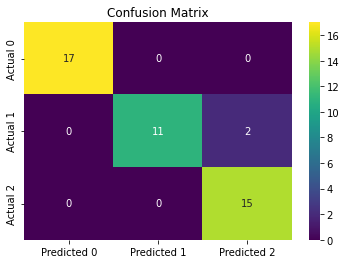

[1 0 3 2]
best k = 1  
Recall/Sensitivity Score:  0.9555555555555556 

Precision Score:  0.9555555555555556 

F1 Score:  0.9555555555555556 



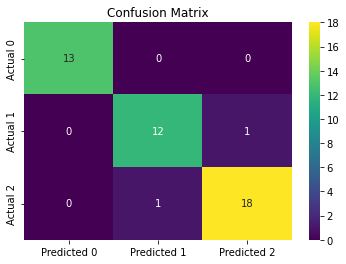

[1 0 3 2]
best k = 7  
Recall/Sensitivity Score:  1.0 

Precision Score:  1.0 

F1 Score:  1.0 



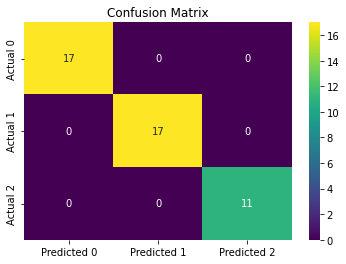

[1 0 3 2]
best k = 3  
Recall/Sensitivity Score:  0.9777777777777777 

Precision Score:  0.9792592592592592 

F1 Score:  0.9778024966011619 



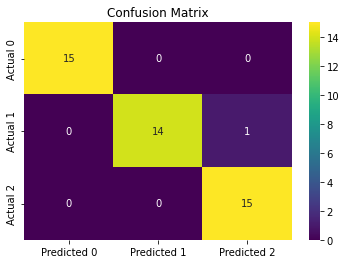

[1 0 3 2]
best k = 9  
Recall/Sensitivity Score:  0.9777777777777777 

Precision Score:  0.9792592592592592 

F1 Score:  0.9778434592227695 



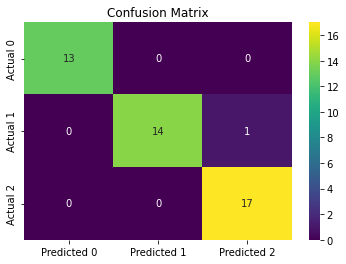

[1 0 3 2]
best k = 7  
Recall/Sensitivity Score:  1.0 

Precision Score:  1.0 

F1 Score:  1.0 



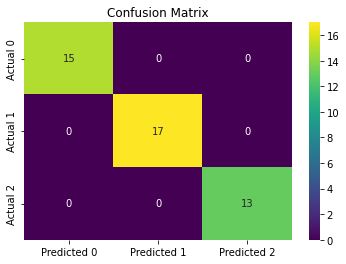

[1 0 3 2]
best k = 7  
Recall/Sensitivity Score:  0.9777777777777777 

Precision Score:  0.9796296296296295 

F1 Score:  0.9779434092477569 



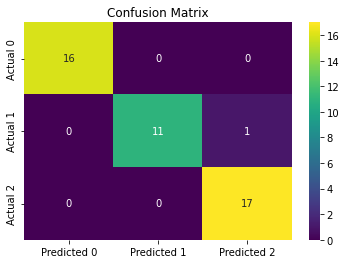

[1 0 3 2]
best k = 3  
Recall/Sensitivity Score:  0.9555555555555556 

Precision Score:  0.9555555555555556 

F1 Score:  0.9555555555555556 



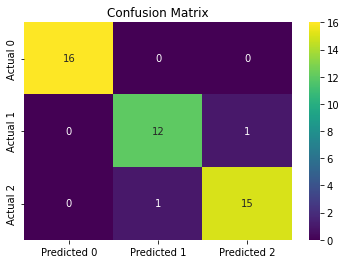

[1 0 3 2]
best k = 11  
Recall/Sensitivity Score:  0.9777777777777777 

Precision Score:  0.9792592592592592 

F1 Score:  0.9778606192399296 



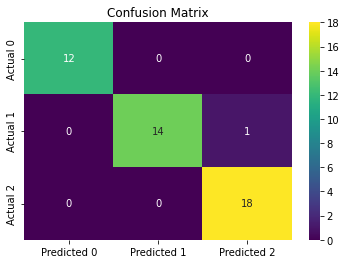

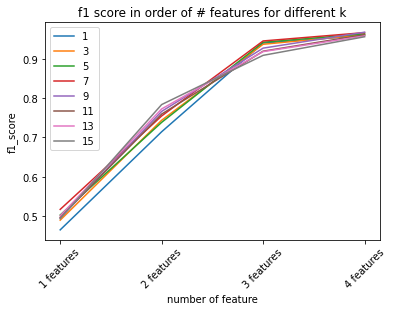

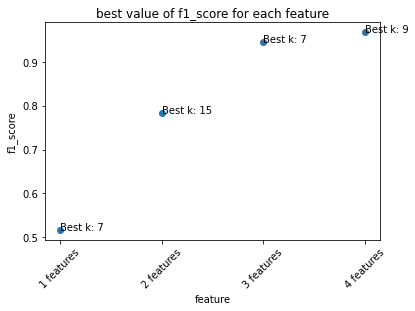

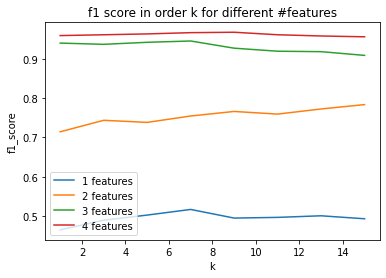

In [102]:
fisher_average(x_data, y_data,20)

# 3

##import csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/TCD/dfAllFeatures.csv"

df_main = pd.read_csv(path)

act_labels = np.array([
    'Stand',
    'Sit',
    'Sit and Talk',
    'Walk',
    'Walk and Talk',
    'Climb Stairs (CS)',
    'CS and Talk',
    'Stand to Sit',
    'Sit to Stand',
    'Stand to Sit and Talk',
    'Sit to Stand and Talk',
    'Stand to Walk',
    'Walk to Stand',
    'Stand to CS/CS and Talk',
    'CS to Walk',
    'CS and Talk to Walk and Talk'
])

def label_to_move(label):
    return act_labels[label-1]

df_main['move'] = df_main['label'].map(label_to_move)



In [ ]:

df_features = df_main.drop('move', axis = 1)
df_features = df_features.drop('label', axis = 1)

features = df_features.keys()

df_features = pd.DataFrame(preprocessing.normalize(df_features), columns = features)

target_move = df_main['move'].unique()
target_label = df_main['label'].unique()

In [ ]:
df_features.head()

,accX_mean,accX_median,accX_std,accX_var,accX_rms,accX_avgDer,accX_skew,accX_kurtosis,accX_iqr,accX_zcr,...,gyroY_DF,gyroZ_DF,accX_ENERGY,accY_ENERGY,accZ_ENERGY,gyroX_ENERGY,gyroY_ENERGY,gyroZ_ENERGY,AAE,ARE
0,0.004985,0.004978,0.000144,0.000012,0.004987,-0.000074,0.000184,0.000861,0.000150,0.0,...,0.0,0.000888,0.000598,0.000355,0.000840,0.191072,0.495031,0.140957,0.001793,0.827060
1,0.004563,0.004558,0.000141,0.000012,0.004565,0.000158,-0.000378,-0.000156,0.000215,0.0,...,0.0,0.000799,0.000631,0.000672,0.001899,0.215717,0.457181,0.167272,0.003202,0.840170
2,0.001555,0.001651,0.000204,0.000071,0.001568,-0.000353,-0.000578,-0.000190,0.000273,0.0,...,0.0,0.000000,0.003590,0.000670,0.000308,0.069362,0.507558,0.244721,0.004568,0.821641
3,0.001209,0.001143,0.000156,0.000045,0.001219,-0.000231,0.000454,-0.000339,0.000249,0.0,...,0.0,0.000000,0.002263,0.000636,0.000206,0.073550,0.508558,0.240355,0.003106,0.822463
4,0.005843,0.005835,0.000291,0.000030,0.005850,0.000225,0.000435,0.001041,0.000379,0.0,...,0.0,0.001425,0.001512,0.001330,0.000560,0.177714,0.449306,0.212689,0.003402,0.839709


##kNN_train_test

Recall/Sensitivity Score:  0.5414937759336099 

Precision Score:  0.5435299189053283 

F1 Score:  0.5419172887375908 

Classifier Score:  0.5414937759336099


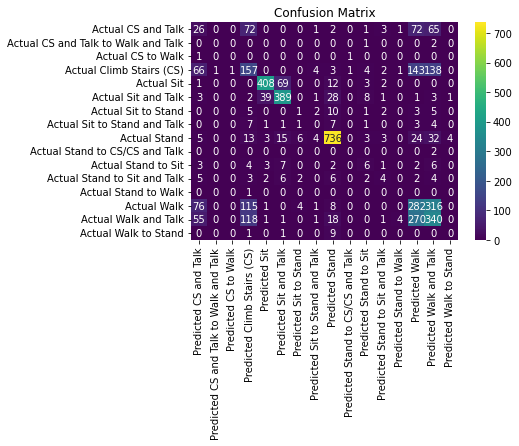

In [ ]:
#70% train e 30% test
kNN_train_test(df_features, df_main['move'],0.3)


## Train Test


0.7111299581917514
Classifier Score:  [1.0, 0.7417704011065007, 0.6922544951590595, 0.6676348547717842, 0.6463347164591978, 0.6417012448132781, 0.6321576763485477, 0.6269709543568465]


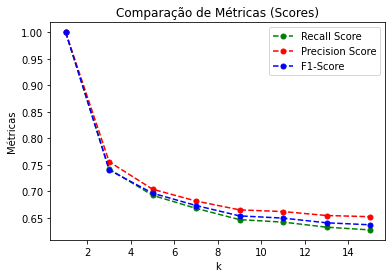

Average f1-score: 0.7111299581917514
Train-Only - Best value of k: k = 1 for f1-score = 1.0


In [ ]:

kNN_Train_v(df_features, df_main['move'],True)

## Train validation Test


#################################################

Recall/Sensitivity Score:  0.5401106500691563 

Precision Score:  0.5396411174110868 

F1 Score:  0.5394624787773624 


#################################################

Recall/Sensitivity Score:  0.5342323651452282 

Precision Score:  0.5353920071890098 

F1 Score:  0.5319622436293469 


#################################################

Recall/Sensitivity Score:  0.5449515905947441 

Precision Score:  0.554649222654078 

F1 Score:  0.5486189890481609 


#################################################

Recall/Sensitivity Score:  0.5470262793914247 

Precision Score:  0.5611782165925752 

F1 Score:  0.5528934891091486 


#################################################

Recall/Sensitivity Score:  0.5508298755186722 

Precision Score:  0.5719005206852485 

F1 Score:  0.5596816291070176 


#################################################

Recall/Sensitivity Score:  0.5549792531120332 

Precision Score:  0.5762761566593599 

F1 Scor

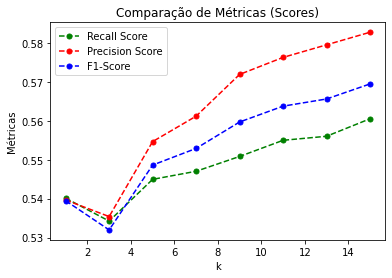

Average f1-score: 0.5539282440517386
Train-Only - Best value of k: k = 15 for f1-score = 0.5694625468481145


In [ ]:
kNN_TVT_v(df_features,df_main['move'],0.2,0.2)



## Cross Validation

f1           0.544621
precision    0.548724
recall       0.542324
dtype: float64
f1           0.541090
precision    0.539896
recall       0.555539
dtype: float64
f1           0.549226
precision    0.547604
recall       0.560166
dtype: float64
f1           0.550536
precision    0.549531
recall       0.561411
dtype: float64
f1           0.552917
precision    0.553284
recall       0.563658
dtype: float64
f1           0.552592
precision    0.552038
recall       0.563589
dtype: float64
f1           0.554593
precision    0.553979
recall       0.565823
dtype: float64
f1           0.552470
precision    0.551830
recall       0.563873
dtype: float64
         f1  precision    recall
0  0.544621   0.548724  0.542324
1  0.541090   0.539896  0.555539
2  0.549226   0.547604  0.560166
3  0.550536   0.549531  0.561411
4  0.552917   0.553284  0.563658
5  0.552592   0.552038  0.563589
6  0.554593   0.553979  0.565823
7  0.552470   0.551830  0.563873


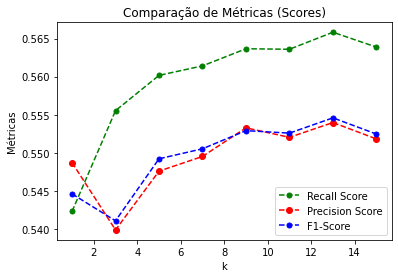

Aaverage f1_score 0.5497555539327011
CV 10*10 - O melhor valor de k é 13 com f1-score = 0.5545929572742716


In [ ]:
CV10_TT_KNN(np.array(df_features),np.array(df_main['label']).reshape(-1,1))

## Relief-F   (PARTE A)

In [ ]:
fs = ReliefF(100, 10)
fs.fit_transform(np.array(df_features),np.array(df_main['label']))
display(fs)

sorted_features = fs.top_features[:10] 
sorted_features

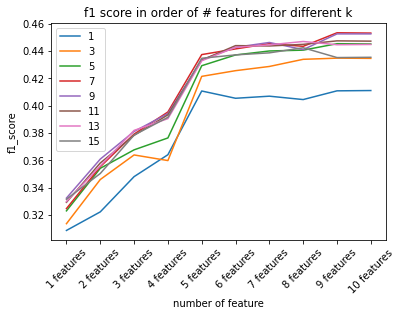

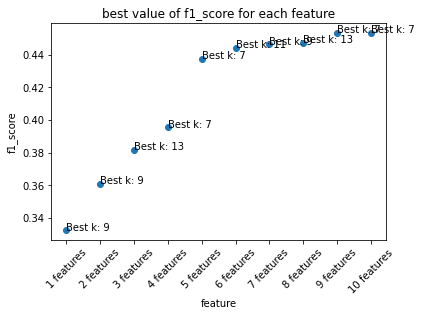

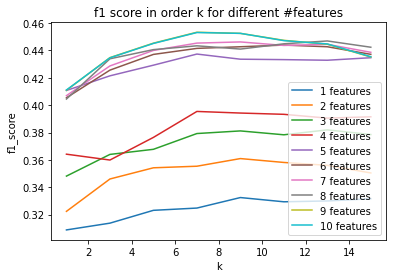

,1,3,5,7,9,11,13,15
1 features,0.308815,0.313762,0.323138,0.324792,0.332478,0.329376,0.329988,0.331626
2 features,0.322391,0.346046,0.354233,0.355384,0.360976,0.358141,0.356028,0.350457
3 features,0.348161,0.364017,0.367745,0.379277,0.381194,0.378361,0.381970,0.378544
4 features,0.364184,0.359906,0.376454,0.395435,0.394257,0.393331,0.390552,0.391532
5 features,0.410771,0.421470,0.429258,0.437388,0.433627,0.433317,0.432872,0.434706
6 features,0.405456,0.425634,0.437126,0.441533,0.442731,0.443951,0.442724,0.437177
7 features,0.406983,0.428710,0.440038,0.445400,0.446255,0.443685,0.444505,0.438663
8 features,0.404511,0.433934,0.440631,0.443420,0.441027,0.444880,0.446971,0.442380
9 features,0.410890,0.434787,0.445351,0.453336,0.452515,0.447428,0.444590,0.435216
10 features,0.411106,0.434624,0.445160,0.453127,0.452520,0.447212,0.444790,0.435416


In [ ]:
sorted_features = fs.top_features[:10] 
sorted_features

main_2_2(np.array(df_features),np.array(df_main['label']), sorted_features)


In [ ]:

# Import time module
import time
 # record start time
start = time.time()


main_relief(np.array(df_features),np.array(df_main['label']),100, 10)


# record end time
end = time.time()
 
# print the difference between start
# and end time in milli. secs
print("The time of execution of above program is :",
      (end-start) * 10**3, "ms")

array([101,  99,  33, 100,  69,  45,  49,  37,  36,  35])

## Fisher Feature Score (PARTE A)

[ 57  59  81  84  85 107  20  53  22  75]


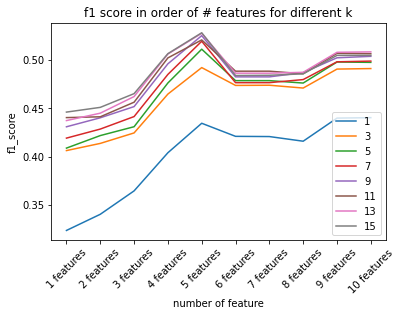

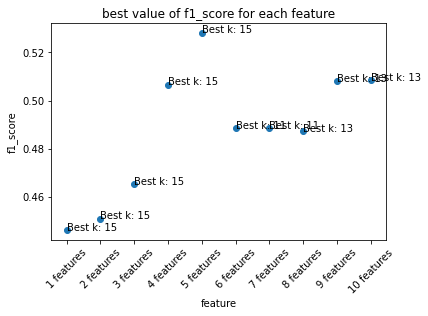

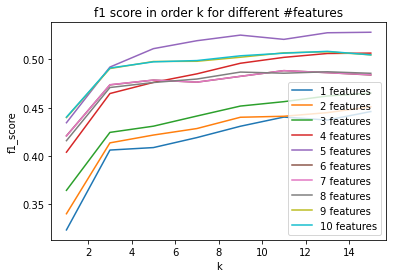

The time of execution of above program is : 47447.211265563965 ms


In [ ]:

# Import time module
import time
 # record start time
start = time.time()


main_fisher(np.array(df_features),np.array(df_main['label']),10)


# record end time
end = time.time()
 
# print the difference between start
# and end time in milli. secs
print("The time of execution of above program is :",
      (end-start) * 10**3, "ms")

# 4

- **Modelo de separação dos dados**: TVT (0.4, 0.3, 0.3)
- **Número de camadas escondidas:** 1 camada escondida
- **Número de neurónios na camada escondida:** 3 a 16
- **Função de ativação:** Função logisitca


Uma função logística ou curva logística tem um formato de S comum (curva sigmoide), com equação:
$$
f(x)=\frac{L}{1+\mathrm{e}^{-k\left(x-x_0\right)}}
$$
Onde $\mathrm{e}=$ base dos logaritmos naturais (também conhecido como número de Euler),
$x_0=$ valor de $x$ no ponto médio da curva sigmoide,
$L=$ valor máximo da curva,
$k=$ declividade da curva.
Para valores de $x$ no domínio dos números reais de $-\infty$ a $+\infty$, a curva sigmoide à direita é obtida com o gráfico de $f$ se aproximando de $L$ conforme $x$ se aproxima de $+\infty$ e se aproximando de zero conforme $x$ se aproxima de $-\infty$


## Data

## 4.1 aprendizagem fixa

‘logistic’, the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).

‘constant’ is a constant learning rate given by ‘learning_rate_init’.





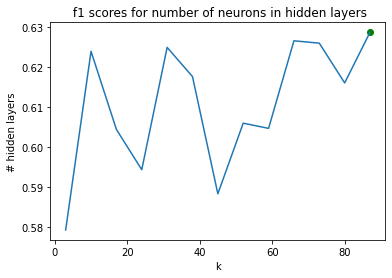

Average f1 score: 0.6107845820976704


In [ ]:

def main_fixed_learning(x,y):
  models = []
  f1_scores = []
  x_train, x_validation, x_test, y_train, y_validation, y_test = Train_Validation_Test(x,y,0.3,0.3)
  hidden = np.arange(3,90,7)
  for hid in hidden:   # Ver o melhor número de neurónios na hidden layer 
    mlp = MLPClassifier(hidden_layer_sizes=(hid), activation='logistic', solver='sgd', learning_rate_init=0.1, learning_rate = "constant")
    mlp.fit(x_train,y_train)
    models.append(mlp) 
    y_pred = mlp.predict(x_validation)
    recall, precision, f1 = metricas(y_pred, y_validation, False)
    f1_scores.append(f1)

  plt.plot(hidden,f1_scores)
  plt.xlabel("k");plt.ylabel("# hidden layers")
  plt.scatter(hidden[np.argmax(f1_scores)], max(f1_scores), color = 'g')
  plt.title(f' f1 scores for number of neurons in hidden layers')
  plt.show()

  print(f"Average f1 score: {np.mean(f1_scores)}")


main_fixed_learning(df_features,df_main['move'])



##4.2 veloc. apredizagem variavel

‘invscaling’ gradually decreases the learning rate at each time step ‘t’ using an inverse scaling exponent of ‘power_t’. effective_learning_rate = learning_rate_init / pow(t, power_t)

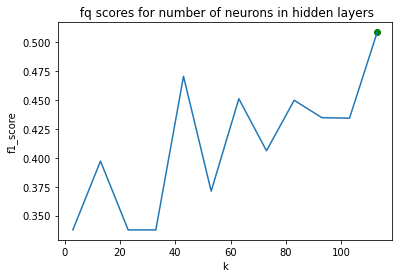

Average f1 score: 0.4113906751842664


In [ ]:
def main_variable_learning(x,y):
  models = []
  f1_scores = []
  x_train, x_validation, x_test, y_train, y_validation, y_test = Train_Validation_Test(x,y,0.3,0.3)
  hidden = np.arange(3,123,10)
  for hid in hidden:   # Ver o melhor número de neurónios na hidden layer 
    mlp = MLPClassifier(hidden_layer_sizes=(hid), activation='logistic', solver='sgd', learning_rate='invscaling') #learning_rate_init=0.1
    mlp.fit(x_train,y_train)
    models.append(mlp)
    y_pred = mlp.predict(x_validation)
    #recall, precision, f1 = metricas(y_pred, y_validation, False)
    recall = recall_score(y_pred, y_validation, average = 'weighted')
    precision = precision_score(y_pred, y_validation, average = 'weighted')
    f1 = f1_score(y_pred, y_validation, average = 'weighted')
    f1_scores.append(f1)

  plt.plot(hidden,f1_scores)
  plt.scatter(hidden[np.argmax(f1_scores)], max(f1_scores), color = 'g')

  plt.xlabel("k");plt.ylabel("f1_score")
  plt.title(f' fq scores for number of neurons in hidden layers')
  plt.show()
  print(f"Average f1 score: {np.mean(f1_scores)}")



main_variable_learning(df_features,df_main['move'])

##4.3 coeficiente de momentum

momentumfloat, default=0.9 Momentum for gradient descent update. Should be between 0 and 1. Only used when solver=’sgd’.

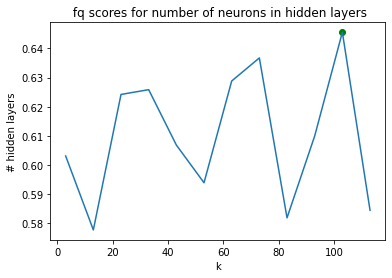

Average f1 score: 0.6099095874551401


In [ ]:
def main_coef_momentum(x,y, momentum_value):
  models = []
  f1_scores = []
  x_train, x_validation, x_test, y_train, y_validation, y_test = Train_Validation_Test(x,y,0.3,0.3)
  hidden = np.arange(3,123,10)
  for hid in hidden:   # Ver o melhor número de neurónios na hidden layer 
    mlp = MLPClassifier(hidden_layer_sizes=(hid), activation='logistic',  momentum = momentum_value)
    mlp.fit(x_train,y_train)
    models.append(mlp)
    y_pred = mlp.predict(x_validation)
    #recall, precision, f1 = metricas(y_pred, y_validation, False)
    recall = recall_score(y_pred, y_validation, average = 'weighted')
    precision = precision_score(y_pred, y_validation, average = 'weighted')
    f1 = f1_score(y_pred, y_validation, average = 'weighted')   
    f1_scores.append(f1)

  plt.plot(hidden,f1_scores)
  plt.scatter(hidden[np.argmax(f1_scores)], max(f1_scores), color = 'g')

  plt.xlabel("k");plt.ylabel("# hidden layers")
  plt.title(f' fq scores for number of neurons in hidden layers')
  plt.show()
  print(f"Average f1 score: {np.mean(f1_scores)}")


main_coef_momentum(df_features,df_main['move'], 0.5)

## 4.4 Comparação de resultados


Observa se que o melhor resultado das redes enuronais é 4.1, seguido de 4.3 e depois 4.2.
De modo a melhorar o resultado das redes neuronais poderiamos variar a função de ativação (relu, Selu, ELU), poderiamos variar o numero de epochs, batch sizes, o numero de neuronios nas camadas escondidas e numerod e hidden layers.

Por outro lado, o k-NN é muito simples e requer o ajuste de apenas um hiperparâmetro (o valor de k), enquanto o treinamento da rede neural envolve muitos hiperparâmetros controlando o tamanho e a estrutura da rede e o procedimento de otimização.https://www.tasq.ai/glossary/algorithm/

#5

#5 Rede Neuronal

In [ ]:
import numpy as np
from sklearn import datasets
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
iris = datasets.load_iris()



## Classe: NN

In [ ]:


class NeuralNetwork:
  def __init__(self, x, y, neuronios, output_len):
    self.neuronios = neuronios
    self.output_len = output_len
    self.input      = x
    self.weights1   = np.random.rand(self.input.shape[1],self.neuronios) 
    self.weights2   = np.random.rand(self.neuronios,self.output_len)                 
    self.y          = y
    self.output     = np.zeros(self.y.shape)


  def sigmoid(self,Z):
      return 1 / (1 + np.exp(-Z))

  def sigmoid_derivative(self,Z):
     return self.sigmoid(Z)*(1-self.sigmoid(Z))


  def feedforward(self):
      self.layer1 = self.sigmoid(np.dot(self.input, self.weights1))
      self.output = self.sigmoid(np.dot(self.layer1, self.weights2))


  def backprop(self):
      # application of the chain rule to find derivative of the loss function with respect to weights2 and weights1
      d_weights2 = np.dot(self.layer1.T, (2*(self.y - self.output) * self.sigmoid_derivative(self.output)))
      d_weights1 = np.dot(self.input.T,  (np.dot(2*(self.y - self.output) * self.sigmoid_derivative(self.output), self.weights2.T) * self.sigmoid_derivative(self.layer1)))

      # update the weights with the derivative (slope) of the loss function
      self.weights1 += d_weights1
      self.weights2 += d_weights2



## IRIS 

In [ ]:
iris = datasets.load_iris()
df = pd.DataFrame(iris['data'])
x_data = StandardScaler().fit_transform(df) 

target = iris['target']



def binary_matrix(target, size):
  new_matrix = np.zeros((len(target),size))
  for i in range(len(new_matrix)):
    new_matrix[i, target[i]] = 1
  return new_matrix

def neuronal(x_data,y_target,neuronios, output_len, epocas):
    nn = NeuralNetwork(x_data,y_target,neuronios, output_len)
    for i in range(epocas):
      nn.feedforward()
      nn.backprop()

    return  nn.output, nn


def acuracy(target,y_pred):
    aux = []
    for i in y_pred:
        aux.append(np.argmax(i))
    pd.DataFrame(aux)

    return accuracy_score(target, aux)


y_target = pd.DataFrame(binary_matrix(target, 3))
y_pred, nn = neuronal(x_data,y_target,4,3, 1000)
acuracy(target,y_pred)

0.76

In [ ]:
def train_test_nn(x, y,neuronios, output_len, epoch):#x_data, y_target

    X_train, X_test, y_train, y_test = train_test_split(x, y)

    y_train_bin = pd.DataFrame(binary_matrix(y_train, 3))     #mudar aqui o numerod e colunas do target
    y_test_bin = pd.DataFrame(binary_matrix(y_test, 3))     #mudar aqui o numerod e colunas do target

    y_pred,nn = neuronal(X_train,y_train_bin,neuronios, output_len,epoch)
    layer1 = nn.sigmoid(np.dot(X_test, nn.weights1))
    output = nn.sigmoid(np.dot(layer1, nn.weights2))
  
    return acuracy(y_test,output)
    

train_test_nn(x_data, target,4,3, 500)

0.7368421052631579

In [ ]:

def train__validation_test_nn(x, y,neuronios, output_len ):#x_data, y_target
    x_train, x_validation, x_test, y_train, y_validation, y_test = Train_Validation_Test(x,y,0.3,0.3)
    y_train_bin = pd.DataFrame(binary_matrix(y_train, 3))     #mudar aqui o numerod e colunas do target
    y_valid_bin = pd.DataFrame(binary_matrix(y_validation, 3))     #mudar aqui o numerod e colunas do target
    y_test_bin = pd.DataFrame(binary_matrix(y_test, 3))     #mudar aqui o numerod e colunas do target
    acc= []
    nn_aux = []
    epochs = np.arange(10,1000,35)
    for i in epochs:
        y_pred, nn = neuronal(x_train,y_train_bin,neuronios, output_len, i)
        layer1 = nn.sigmoid(np.dot(x_validation, nn.weights1))
        output = nn.sigmoid(np.dot(layer1, nn.weights2))
       # acuracy(y_test,StandardScaler().fit_transform(output).tolist())
        acc.append(acuracy(y_validation,StandardScaler().fit_transform(output).tolist()))
        nn_aux.append(nn)

    index = np.argmax(acc)            #index da melhor rede
    nn_best = nn_aux[index]           #usa a melhor rede


    layer1 = nn_best.sigmoid(np.dot(np.concatenate((x_train, x_validation)), nn_best.weights1))    #treinar com treino + validação para o melhor treino
    output = nn_best.sigmoid(np.dot(layer1, nn_best.weights2))

    layer_test = nn_best.sigmoid(np.dot(x_test, nn_best.weights1)) #prever o teste
    output_test = nn_best.sigmoid(np.dot(layer_test, nn_best.weights2)) 
    return acuracy(y_test,output_test)

train__validation_test_nn(x_data, target,4,3)

0.8444444444444444

## HUMAN 

### Train Only

In [ ]:
def TT_nn(x,y):
  y_bin = pd.DataFrame(binary_matrix(y, 17))     #mudar aqui o numerod e colunas do target
  y_pred,nn = neuronal(x,y_bin,150, 17,1000)
  layer1 = nn.sigmoid(np.dot(x, nn.weights1))
  output = nn.sigmoid(np.dot(layer1, nn.weights2))
  return acuracy(y,output)

acuracy = TT_nn(df_features,df_main['label'])
acuracy

0.33838174273858923

### Train Validation Test

##Estudo de epocas

epoch SUCESS
epoch SUCESS
epoch SUCESS
epoch SUCESS
epoch SUCESS
epoch SUCESS
epoch SUCESS
epoch SUCESS


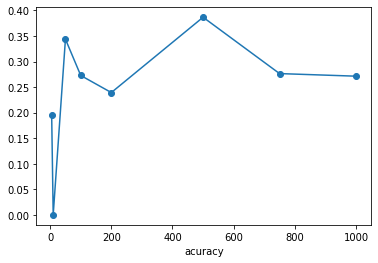

In [ ]:

def train__validation_test_nn_human(x, y,neuronios, output_len ):#x_data, y_target
  x_train, x_validation, x_test, y_train, y_validation, y_test = Train_Validation_Test(x,y,0.3,0.3)
  y_train_bin = pd.DataFrame(binary_matrix(np.array(y_train), 17))     #mudar aqui o numerod e colunas do target
  y_valid_bin = pd.DataFrame(binary_matrix(np.array(y_validation), 17))     #mudar aqui o numerod e colunas do target
  y_test_bin = pd.DataFrame(binary_matrix(np.array(y_test), 17))     #mudar aqui o numerod e colunas do target
  acc= []
  nn_aux = []
  epochs = [5,10,50,100,200,500,750,1000]
  for i in epochs:
    y_pred, nn = neuronal(x_train,y_train_bin,neuronios, output_len, i)
    layer1 = nn.sigmoid(np.dot(x_validation, nn.weights1))
    output = nn.sigmoid(np.dot(layer1, nn.weights2))
    acc.append(acuracy(y_validation,output))
    nn_aux.append(nn)
    print('epoch SUCESS')
  index = np.argmax(acc)            #index da melhor rede
  nn_best = nn_aux[index]           #usa a melhor rede
  

  layer1 = nn_best.sigmoid(np.dot(np.concatenate((x_train, x_validation)), nn_best.weights1))    #treinar com treino + validação para o melhor treino
  output = nn_best.sigmoid(np.dot(layer1, nn_best.weights2))

  layer_test = nn_best.sigmoid(np.dot(x_test, nn_best.weights1)) #prever o teste
  output_test = nn_best.sigmoid(np.dot(layer_test, nn_best.weights2)) 

  plt.plot(epochs, acc)
  plt.scatter(epochs, acc)
  plt.xlabel('k')
  plt.xlabel('acuracy')
  plt.show()
  return acuracy(y_test,output_test),acc,epochs

acc_best,acc_vector,epochs = train__validation_test_nn_human(df_features,df_main['label'],150,17)


## Estudo de neuronios

epoch SUCESS
epoch SUCESS
epoch SUCESS
epoch SUCESS
epoch SUCESS
epoch SUCESS
epoch SUCESS


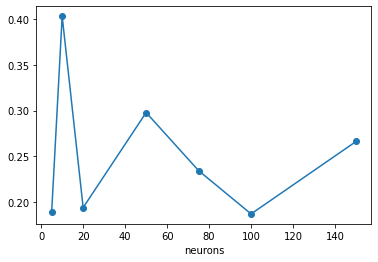

In [ ]:

def neuron_experiments(x, y,epochs, output_len ):#x_data, y_target
  x_train, x_validation, x_test, y_train, y_validation, y_test = Train_Validation_Test(x,y,0.3,0.3)
  y_train_bin = pd.DataFrame(binary_matrix(np.array(y_train), 17))     #mudar aqui o numerod e colunas do target
  y_valid_bin = pd.DataFrame(binary_matrix(np.array(y_validation), 17))     #mudar aqui o numerod e colunas do target
  y_test_bin = pd.DataFrame(binary_matrix(np.array(y_test), 17))     #mudar aqui o numerod e colunas do target
  acc= []
  nn_aux = []
  neurons = [5,10,20,50,75,100,150]
  for i in neurons:
    y_pred, nn = neuronal(x_train,y_train_bin,i, output_len, 500)
    layer1 = nn.sigmoid(np.dot(x_validation, nn.weights1))
    output = nn.sigmoid(np.dot(layer1, nn.weights2))
    acc.append(acuracy(y_validation,output))
    nn_aux.append(nn)
    print('epoch SUCESS')
  index = np.argmax(acc)            #index da melhor rede
  nn_best = nn_aux[index]           #usa a melhor rede
  

  layer1 = nn_best.sigmoid(np.dot(np.concatenate((x_train, x_validation)), nn_best.weights1))    #treinar com treino + validação para o melhor treino
  output = nn_best.sigmoid(np.dot(layer1, nn_best.weights2))

  layer_test = nn_best.sigmoid(np.dot(x_test, nn_best.weights1)) #prever o teste
  output_test = nn_best.sigmoid(np.dot(layer_test, nn_best.weights2)) 

  plt.plot(neurons, acc)
  plt.scatter(neurons, acc)
  plt.xlabel('accuracy')
  plt.xlabel('neurons')
  plt.show()
  return acuracy(y_test,output_test),acc,epochs

acc_best,acc_vector,epochs = neuron_experiments(df_features,df_main['label'],500,17)


################################FIM#######################################